# Trajectory Analysis

This notebook generates trajectory visualization plots for detailed analysis of policy behavior.

**Features:**
- Runs `wandb_eval.py` via subprocess if trajectory data doesn't exist
- Multi-panel trajectory plots with phase annotations
- Break analysis by phase
- Selection confidence comparison
- Selection probability trajectories by phase

In [ ]:
# ============================================================
# BLOCK 1: IMPORTS & CONSTANTS
# ============================================================

import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import pickle
import subprocess
import os
import sys
from pathlib import Path
from collections import defaultdict
from typing import Dict, List, Tuple, Optional, Union

# WandB Configuration
ENTITY = "hur"
PROJECT = "SG_Exps"

# Method Tags - internal name -> wandb tag
METHOD_TAGS = {
    #"Pose(1mm)": "pose_task_frag:2026-01-06_00:52",
    #"Pose(2.5mm)" : "pose_25mm-noise:2026-01-19_07:50_15N",
    #"Pose-7.5mm":"pose_75mm-noise:2026-01-17_19:18",
    #"MATCH(1mm)": "LCLoP_task_frag:2026-01-06_00:27",
    #"Hybrid-Basic(1mm)": "basic-hybrid_task_frag:2026-01-06_00:56",

    # hex
    #"Pose": "pose_hex:2026-01-13_22:49",
    #"SWISH": "LCLoP_hex:2026-01-13_22:49",


    #"Pose(1mm)": "pose_base-case:2026-02-02_13:40",
    #"Pose(2.5mm)": "pose_25mm:2026-02-02_13:40",
    #"MATCH(1mm)": "MATCH_base-case:2026-02-04_17:46",
    #"Hybrid-Basic(1mm)": "basic-hybrid_base-case:2026-02-02_13:40",

    "Pose(1mm)": "pose_breakable_f10N:2026-02-04_17:49",
    #"Pose(2.5mm)": "pose_25mm_f10:2026-02-05_22:12",
    "MATCH(1mm)": "MATCH_breakable_10N:2026-02-04_17:49",
    #"Hybrid-Basic(1mm)": "basic-hybrid_breakable_f10N:2026-02-04_17:49",
}

# Method display settings
METHOD_COLORS = {
    "Pose(1mm)": "#2ca02c",        # Green
    "Hybrid-Basic": "#ff7f0e", # Orange
    "MATCH(1mm)": "#1f77b4",       # Blue
}

# Evaluation Tags
TAG_EVAL_PERFORMANCE = "eval_performance"

# Metrics for best policy selection
METRIC_SUCCESS = "num_successful_completions"
METRIC_BREAKS = "num_breaks"

# Trajectory Evaluation Configuration
WANDB_EVAL_SCRIPT = "../../eval/wandb_eval.py"  # Relative to this notebook
TRAJ_OUTPUT_BASE = "../../eval/traj_data"  # Base directory for trajectory data

# Phase definitions (matching traj_vis.ipynb)
PHASES = ['approaching', 'initial_contact', 'insertion']
PHASE_COLORS = {
    'approaching': '#90EE90',      # Light green
    'initial_contact': '#FFD700',  # Gold
    'insertion': '#87CEEB',        # Sky blue
}

# Outcome definitions
OUTCOMES = ['success', 'break', 'timeout']

In [ ]:
# ============================================================
# BLOCK 2: DETERMINE BEST POLICY
# ============================================================

def get_best_checkpoint_per_run(api, method_tag):
    """
    Find the best checkpoint for each training run based on eval_performance runs.
    
    Returns dict mapping training_run_id -> {run_name, best_step, score, eval_run_id}
    """
    # Query eval runs
    eval_runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": TAG_EVAL_PERFORMANCE}]}
    )
    
    # Query training runs (have method_tag but NOT eval_performance)
    training_runs = api.runs(
        f"{ENTITY}/{PROJECT}",
        filters={"$and": [{"tags": method_tag}, {"tags": {"$ne": TAG_EVAL_PERFORMANCE}}]}
    )
    
    # Build lookup: training run name -> training run id
    training_run_lookup = {}
    for run in training_runs:
        training_run_lookup[run.name] = run.id
    
    print(f"  Found {len(training_run_lookup)} training runs")
    
    best_checkpoints = {}
    for eval_run in eval_runs:
        history = eval_run.history()
        if history.empty:
            print(f"  Warning: Eval run {eval_run.name} has no history data")
            continue
        
        # Calculate score: successes - breaks
        history["score"] = history[f"Eval_Core/{METRIC_SUCCESS}"] - history[f"Eval_Core/{METRIC_BREAKS}"]
        best_idx = history["score"].idxmax()
        best_step = int(history.loc[best_idx, "total_steps"])
        
        # Extract training run name from eval run name
        # Eval run: "Eval_performance_pose_perf-comp_f(10)_0"
        # Training run: "pose_perf-comp_f(10)_0"
        eval_run_name = eval_run.name
        if eval_run_name.startswith("Eval_performance_"):
            training_run_name = eval_run_name[len("Eval_performance_"):]
        elif eval_run_name.startswith("Eval_noise_"):
            training_run_name = eval_run_name[len("Eval_noise_"):]
        else:
            # Try to find a matching training run by suffix
            training_run_name = eval_run_name
        
        # Look up training run ID
        if training_run_name not in training_run_lookup:
            print(f"  Warning: Could not find training run for eval run {eval_run_name}")
            print(f"    Expected training run name: {training_run_name}")
            continue
        
        training_run_id = training_run_lookup[training_run_name]
        
        best_checkpoints[training_run_id] = {
            "run_name": training_run_name,
            "best_step": best_step,
            "score": history.loc[best_idx, "score"],
            "eval_run_id": eval_run.id,
            "eval_run_name": eval_run_name,
        }
        print(f"    {training_run_name} (train:{training_run_id}): best checkpoint at step {best_step} (score: {history.loc[best_idx, 'score']:.0f})")
    
    return best_checkpoints

# Get best checkpoints for each method
api = wandb.Api()
best_checkpoints = {}  # best_checkpoints[method]

for method_name, method_tag in METHOD_TAGS.items():
    print(f"\n{'='*60}")
    print(f"Method: {method_name} ({method_tag})")
    print(f"{'='*60}")
    best_checkpoints[method_name] = get_best_checkpoint_per_run(api, method_tag)

wandb: Currently logged in as: robonuke (hur) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin



Method: Pose(1mm) (pose_breakable_f10N:2026-02-04_17:49)
  Found 15 training runs
    pose_breakable_f(10)_0 (train:k90prlbx): best checkpoint at step 2188800 (score: 93)
    pose_breakable_f(10)_1 (train:6r4liews): best checkpoint at step 1804800 (score: 91)
    pose_breakable_f(10)_2 (train:4t553y8v): best checkpoint at step 1843200 (score: 92)
    pose_breakable_f(10)_3 (train:54gdfza4): best checkpoint at step 2419200 (score: 92)
    pose_breakable_f(10)_4 (train:46f1mxa0): best checkpoint at step 38400 (score: 0)

Method: MATCH(1mm) (MATCH_breakable_10N:2026-02-04_17:49)
  Found 15 training runs
    MATCH_breakable_f(10)_0 (train:of3r2sqa): best checkpoint at step 1075200 (score: 95)
    MATCH_breakable_f(10)_1 (train:jxbubm3w): best checkpoint at step 1651200 (score: 97)
    MATCH_breakable_f(10)_2 (train:cev3fqe4): best checkpoint at step 2265600 (score: 97)
    MATCH_breakable_f(10)_3 (train:mcsh8h2p): best checkpoint at step 1497600 (score: 82)
    MATCH_breakable_f(10)_4 (tr

In [ ]:
# ============================================================
# BLOCK 3: RUN TRAJECTORY EVALUATION (IF NEEDED)
# ============================================================

# Get absolute paths for the script and output directory
NOTEBOOK_DIR = os.path.dirname(os.path.abspath("__file__"))
PROJECT_ROOT = os.path.abspath(os.path.join(NOTEBOOK_DIR, "../.."))
WANDB_EVAL_SCRIPT_ABS = os.path.join(PROJECT_ROOT, "eval/wandb_eval.py")
TRAJ_OUTPUT_BASE_ABS = os.path.join(PROJECT_ROOT, "eval/traj_data")

print(f"Project root: {PROJECT_ROOT}")
print(f"Eval script: {WANDB_EVAL_SCRIPT_ABS}")
print(f"Output base: {TRAJ_OUTPUT_BASE_ABS}")


def get_traj_output_path(method_tag: str) -> str:
    """Get the output directory for trajectory data for a method."""
    # Format: {base}/{tag}/
    safe_tag = method_tag.replace(":", "_").replace("/", "_")
    return os.path.join(TRAJ_OUTPUT_BASE_ABS, safe_tag)


def check_run_data_exists(output_dir: str, run_id: str, checkpoint: int) -> bool:
    """Check if trajectory data exists for a specific run and checkpoint."""
    run_dir = os.path.join(output_dir, run_id)
    if not os.path.exists(run_dir):
        return False
    
    # Check for the specific checkpoint pkl file
    pkl_file = f"traj_{checkpoint}.pkl"
    return os.path.exists(os.path.join(run_dir, pkl_file))


def run_trajectory_eval(
    method_tag: str,
    checkpoint: int,
    output_dir: str,
    run_id: str,
    dry_run: bool = False
) -> bool:
    """
    Run wandb_eval.py with trajectory mode for a specific run and checkpoint.
    
    Args:
        method_tag: WandB tag for the method
        checkpoint: Checkpoint step to evaluate
        output_dir: Directory to save trajectory data
        run_id: Specific run ID to evaluate
        dry_run: If True, print command without executing
        
    Returns:
        True if successful, False otherwise
    """
    cmd = [
        sys.executable, WANDB_EVAL_SCRIPT_ABS,
        "--tag", method_tag,
        "--checkpoint", str(checkpoint),
        "--eval_mode", "trajectory",
        "--traj_output_dir", output_dir,
        "--entity", ENTITY,
        "--project", PROJECT,
        "--run_id", run_id,
    ]
    
    print(f"\nCommand: {' '.join(cmd)}")
    print(f"Working directory: {PROJECT_ROOT}")
    
    if dry_run:
        print("[DRY RUN] Would execute above command")
        return True
    
    try:
        # Set up environment with PYTHONPATH including project root
        env = os.environ.copy()
        pythonpath = env.get('PYTHONPATH', '')
        if pythonpath:
            env['PYTHONPATH'] = f"{PROJECT_ROOT}:{pythonpath}"
        else:
            env['PYTHONPATH'] = PROJECT_ROOT
        
        print(f"PYTHONPATH: {env['PYTHONPATH']}")
        
        # Use Popen to stream output in real-time
        print("\n" + "-"*60)
        print(f"Starting trajectory evaluation for {run_id} at checkpoint {checkpoint}...")
        print("-"*60 + "\n")
        
        process = subprocess.Popen(
            cmd,
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True,
            cwd=PROJECT_ROOT,
            env=env,
        )
        
        # Stream output line by line
        output_lines = []
        for line in process.stdout:
            print(line, end='')
            output_lines.append(line)
        
        # Wait for process to complete
        return_code = process.wait()
        
        # Check for Python exceptions
        output_text = ''.join(output_lines)
        has_python_exception = 'Traceback (most recent call last):' in output_text
        has_module_error = 'ModuleNotFoundError:' in output_text
        
        # Check for success indicators
        has_success = 'Evaluation complete!' in output_text or 'Saved trajectory data' in output_text
        
        print("\n" + "-"*60)
        if return_code != 0:
            print(f"Trajectory evaluation FAILED with return code: {return_code}")
            return False
        elif has_python_exception or has_module_error:
            print(f"Trajectory evaluation FAILED (Python exception detected)")
            return False
        elif has_success:
            print("Trajectory evaluation completed successfully!")
            return True
        else:
            print("Trajectory evaluation completed (no explicit success/failure detected)")
            return True
            
    except subprocess.TimeoutExpired:
        print("Trajectory evaluation timed out after 1 hour")
        process.kill()
        return False
    except Exception as e:
        print(f"Exception running trajectory eval: {e}")
        import traceback
        traceback.print_exc()
        return False


# Configuration for this run
DRY_RUN = False  # Set to False to actually run evaluations
FORCE_RERUN = False  # Set to True to re-run even if data exists

# Check and run trajectory evaluations for each run at its own best checkpoint
# Process ONE RUN AT A TIME to avoid multiple Isaac Sim instances
traj_data_paths = {}  # traj_data_paths[method] = output_dir

methods_to_process = list(METHOD_TAGS.items())
evaluation_failed = False

for method_name, method_tag in methods_to_process:
    print(f"\n{'='*60}")
    print(f"Processing: {method_name}")
    print(f"{'='*60}")
    
    method_checkpoints = best_checkpoints.get(method_name, {})
    if not method_checkpoints:
        print(f"  No checkpoints found for {method_name}")
        continue
    
    # Output directory is per-method (not per-checkpoint)
    output_dir = get_traj_output_path(method_tag)
    traj_data_paths[method_name] = output_dir
    
    # Process each run individually at its own best checkpoint
    for run_id, run_info in method_checkpoints.items():
        run_name = run_info["run_name"]
        best_step = run_info["best_step"]
        score = run_info["score"]
        
        print(f"\n  Run: {run_name} (id: {run_id})")
        print(f"    Best checkpoint: {best_step} (score: {score})")
        
        # Check if data already exists for this run
        if check_run_data_exists(output_dir, run_id, best_step) and not FORCE_RERUN:
            print(f"    Data exists, skipping")
            continue
        
        print(f"    Running trajectory evaluation...")
        
        success = run_trajectory_eval(
            method_tag, best_step, output_dir, run_id, dry_run=DRY_RUN
        )
        
        if not success and not DRY_RUN:
            print(f"\n  WARNING: Evaluation failed for {run_name}")
            print(f"  Stopping to avoid repeated failures.")
            evaluation_failed = True
            break
    
    if evaluation_failed:
        break

# Summary
print("\n" + "="*60)
print("TRAJECTORY DATA SUMMARY")
print("="*60)

for method_name, output_dir in traj_data_paths.items():
    print(f"\n{method_name}:")
    print(f"  Path: {output_dir}")
    
    if not os.path.exists(output_dir):
        print(f"  Status: MISSING (no data)")
        continue
    
    method_checkpoints = best_checkpoints.get(method_name, {})
    total_runs = len(method_checkpoints)
    found_runs = 0
    
    for run_id, run_info in method_checkpoints.items():
        best_step = run_info["best_step"]
        exists = check_run_data_exists(output_dir, run_id, best_step)
        status = "OK" if exists else "MISSING"
        if exists:
            found_runs += 1
        print(f"    {run_info['run_name']}: checkpoint {best_step} [{status}]")
    
    print(f"  Total: {found_runs}/{total_runs} runs have data")

Project root: /home/hunter/Continuous_Force_RL
Eval script: /home/hunter/Continuous_Force_RL/eval/wandb_eval.py
Output base: /home/hunter/Continuous_Force_RL/eval/traj_data

Processing: Pose(1mm)

  Run: pose_breakable_f(10)_0 (id: k90prlbx)
    Best checkpoint: 2188800 (score: 93)
    Running trajectory evaluation...

Command: /home/hunter/miniconda3/envs/isaaclab_drail/bin/python /home/hunter/Continuous_Force_RL/eval/wandb_eval.py --tag pose_breakable_f10N:2026-02-04_17:49 --checkpoint 2188800 --eval_mode trajectory --traj_output_dir /home/hunter/Continuous_Force_RL/eval/traj_data/pose_breakable_f10N_2026-02-04_17_49 --entity hur --project SG_Exps --run_id k90prlbx
Working directory: /home/hunter/Continuous_Force_RL
PYTHONPATH: /home/hunter/Continuous_Force_RL

------------------------------------------------------------
Starting trajectory evaluation for k90prlbx at checkpoint 2188800...
------------------------------------------------------------

Parsing arguments...
Launching Isa

In [ ]:
# ============================================================
# BLOCK 4: DATA LOADING FUNCTIONS
# ============================================================

def _standardize_step(step: Dict) -> Dict:
    """
    Ensure step dict has all expected fields with correct format.
    Converts numpy arrays to lists, handles missing fields with defaults.
    """
    field_map = {
        'contact_force': ['contact_force', 'force', 'wrench'],
        'contact_state': ['contact_state', 'in_contact', 'contact'],
        'control_selection': ['control_selection', 'mode_selection', 'selection'],
        'control_probability': ['control_probability', 'mode_prob', 'selection_prob'],
        'velocity': ['velocity', 'ee_velocity', 'vel'],
        'position_error': ['position_error', 'pos_error', 'pos_err'],
        'force_error': ['force_error', 'f_error', 'force_err'],
        'phase': ['phase'],
        'peg_pos': ['peg_pos', 'ee_pos', 'position'],
        'terminated': ['terminated', 'done', 'terminal'],
        'rewards': ['rewards', 'reward'],
    }
    
    def get_field(data, keys, default=None):
        for k in keys:
            if k in data:
                val = data[k]
                if hasattr(val, 'tolist'):
                    return val.tolist()
                return val
        return default
    
    return {
        'step': step.get('step', 0),
        'phase': get_field(step, field_map['phase'], 'unknown'),
        'contact_force': get_field(step, field_map['contact_force'], [0, 0, 0]),
        'contact_state': get_field(step, field_map['contact_state'], False),
        'control_selection': get_field(step, field_map['control_selection'], [0, 0, 0]),
        'control_probability': get_field(step, field_map['control_probability'], [0.5, 0.5, 0.5]),
        'velocity': get_field(step, field_map['velocity'], [0, 0, 0]),
        'position_error': get_field(step, field_map['position_error'], [0, 0, 0]),
        'force_error': get_field(step, field_map['force_error'], [0, 0, 0]),
        'peg_pos': get_field(step, field_map['peg_pos'], None),
        'terminated': get_field(step, field_map['terminated'], False),
        'rewards': get_field(step, field_map['rewards'], {}),
    }


def _parse_episode(raw_ep: Dict, policy: str, episode_id: str, run_id: str) -> Tuple[Dict, Optional[Dict]]:
    """Parse a single episode into standardized format."""
    steps = raw_ep.get('policy_steps', raw_ep.get('steps', raw_ep.get('trajectory', [])))
    
    hole_pos = raw_ep.get('hole_pos', None)
    initial_peg_pos = raw_ep.get('initial_peg_pos', None)
    
    if hole_pos is not None and hasattr(hole_pos, 'tolist'):
        hole_pos = hole_pos.tolist()
    if initial_peg_pos is not None and hasattr(initial_peg_pos, 'tolist'):
        initial_peg_pos = initial_peg_pos.tolist()
    
    standardized_steps = []
    for s in steps:
        std_step = _standardize_step(s)
        
        # Compute insertion_depth and lateral_error if we have hole_pos and peg_pos
        if hole_pos is not None and std_step.get('peg_pos') is not None:
            peg_pos = std_step['peg_pos']
            std_step['insertion_depth'] = hole_pos[2] - peg_pos[2]
            # Lateral error = XY distance from peg to hole center
            std_step['lateral_error'] = ((peg_pos[0] - hole_pos[0])**2 + (peg_pos[1] - hole_pos[1])**2)**0.5
        
        standardized_steps.append(std_step)
    
    break_sim_steps = raw_ep.get('break_sim_steps', None)
    
    # Infer outcome
    outcome = raw_ep.get('outcome', None)
    if outcome is None:
        outcome = 'success' if any(s.get('terminated', False) for s in steps) else 'timeout'
    
    parsed_episode = {
        'policy': policy,
        'episode_id': episode_id,
        'run_id': run_id,
        'outcome': outcome,
        'steps': standardized_steps,
        'hole_pos': hole_pos,
        'initial_peg_pos': initial_peg_pos,
    }
    
    break_event = None
    if outcome == 'break' and break_sim_steps is not None:
        break_event = {
            'policy': policy,
            'episode_id': episode_id,
            'run_id': run_id,
            'sim_steps': [_standardize_step(s) for s in break_sim_steps]
        }
    
    return parsed_episode, break_event


def load_trajectory_data_for_method(
    output_dir: str,
    policy_name: str,
    method_checkpoints: Dict[str, Dict],
    verbose: bool = True
) -> Tuple[List[Dict], List[Dict]]:
    """
    Load trajectory data from .pkl files for a method.
    
    Each run has its own best checkpoint, so we load the specific pkl file
    for each run based on its checkpoint.
    
    Args:
        output_dir: Directory containing run subdirectories with .pkl files
        policy_name: Name to assign to this policy
        method_checkpoints: Dict mapping run_id -> {run_name, best_step, score}
        verbose: Print loading progress
        
    Returns:
        Tuple of (episode_data, break_events)
    """
    output_dir = os.path.abspath(output_dir)
    
    if not os.path.exists(output_dir):
        if verbose:
            print(f"Warning: Output directory does not exist: {output_dir}")
        return [], []
    
    episode_data = []
    break_events = []
    load_stats = {'runs': 0, 'episodes': 0, 'breaks': 0}
    
    for run_id, run_info in method_checkpoints.items():
        best_step = run_info["best_step"]
        run_dir = os.path.join(output_dir, run_id)
        pkl_file = f"traj_{best_step}.pkl"
        pkl_path = os.path.join(run_dir, pkl_file)
        
        if not os.path.exists(pkl_path):
            if verbose:
                print(f"  Warning: Missing {pkl_file} for run {run_id}")
            continue
        
        try:
            with open(pkl_path, 'rb') as f:
                raw_data = pickle.load(f)
            
            # Parse the trajectory data
            if isinstance(raw_data, dict) and 'trajectories' in raw_data:
                trajectories = raw_data['trajectories']
                for env_key, env_data in trajectories.items():
                    env_idx = int(env_key.replace('env_', ''))
                    episode_id = f"{run_id}_env_{env_idx}"
                    parsed_ep, break_event = _parse_episode(env_data, policy_name, episode_id, run_id)
                    episode_data.append(parsed_ep)
                    load_stats['episodes'] += 1
                    if break_event is not None:
                        break_events.append(break_event)
                        load_stats['breaks'] += 1
            
            load_stats['runs'] += 1
            
        except Exception as e:
            if verbose:
                print(f"  Error loading {pkl_path}: {e}")
    
    if verbose:
        print(f"  Loaded {policy_name}: {load_stats['runs']} runs, {load_stats['episodes']} episodes, {load_stats['breaks']} breaks")
    
    return episode_data, break_events


# Load all trajectory data
all_episode_data = []
all_break_events = []

print("Loading trajectory data...")
for method_name, output_dir in traj_data_paths.items():
    method_checkpoints = best_checkpoints.get(method_name, {})
    episodes, breaks = load_trajectory_data_for_method(
        output_dir, method_name, method_checkpoints
    )
    all_episode_data.extend(episodes)
    all_break_events.extend(breaks)

print(f"\nTotal: {len(all_episode_data)} episodes, {len(all_break_events)} break events")

# Print outcome breakdown
if all_episode_data:
    outcome_counts = defaultdict(lambda: defaultdict(int))
    for ep in all_episode_data:
        outcome_counts[ep['policy']][ep['outcome']] += 1
    
    print("\nOutcome breakdown:")
    for policy in sorted(outcome_counts.keys()):
        counts = outcome_counts[policy]
        print(f"  {policy}: success={counts['success']}, break={counts['break']}, timeout={counts['timeout']}")


Loading trajectory data...
  Loaded Pose(1mm): 5 runs, 500 episodes, 5 breaks
  Loaded MATCH(1mm): 5 runs, 500 episodes, 8 breaks

Total: 1000 episodes, 13 break events

Outcome breakdown:
  MATCH(1mm): success=473, break=8, timeout=19
  Pose(1mm): success=368, break=5, timeout=127


Computed phase proportions from data:
  approaching: 33.3% (avg 24.1 steps)
  initial_contact: 19.3% (avg 13.9 steps)
  insertion: 47.4% (avg 34.3 steps)


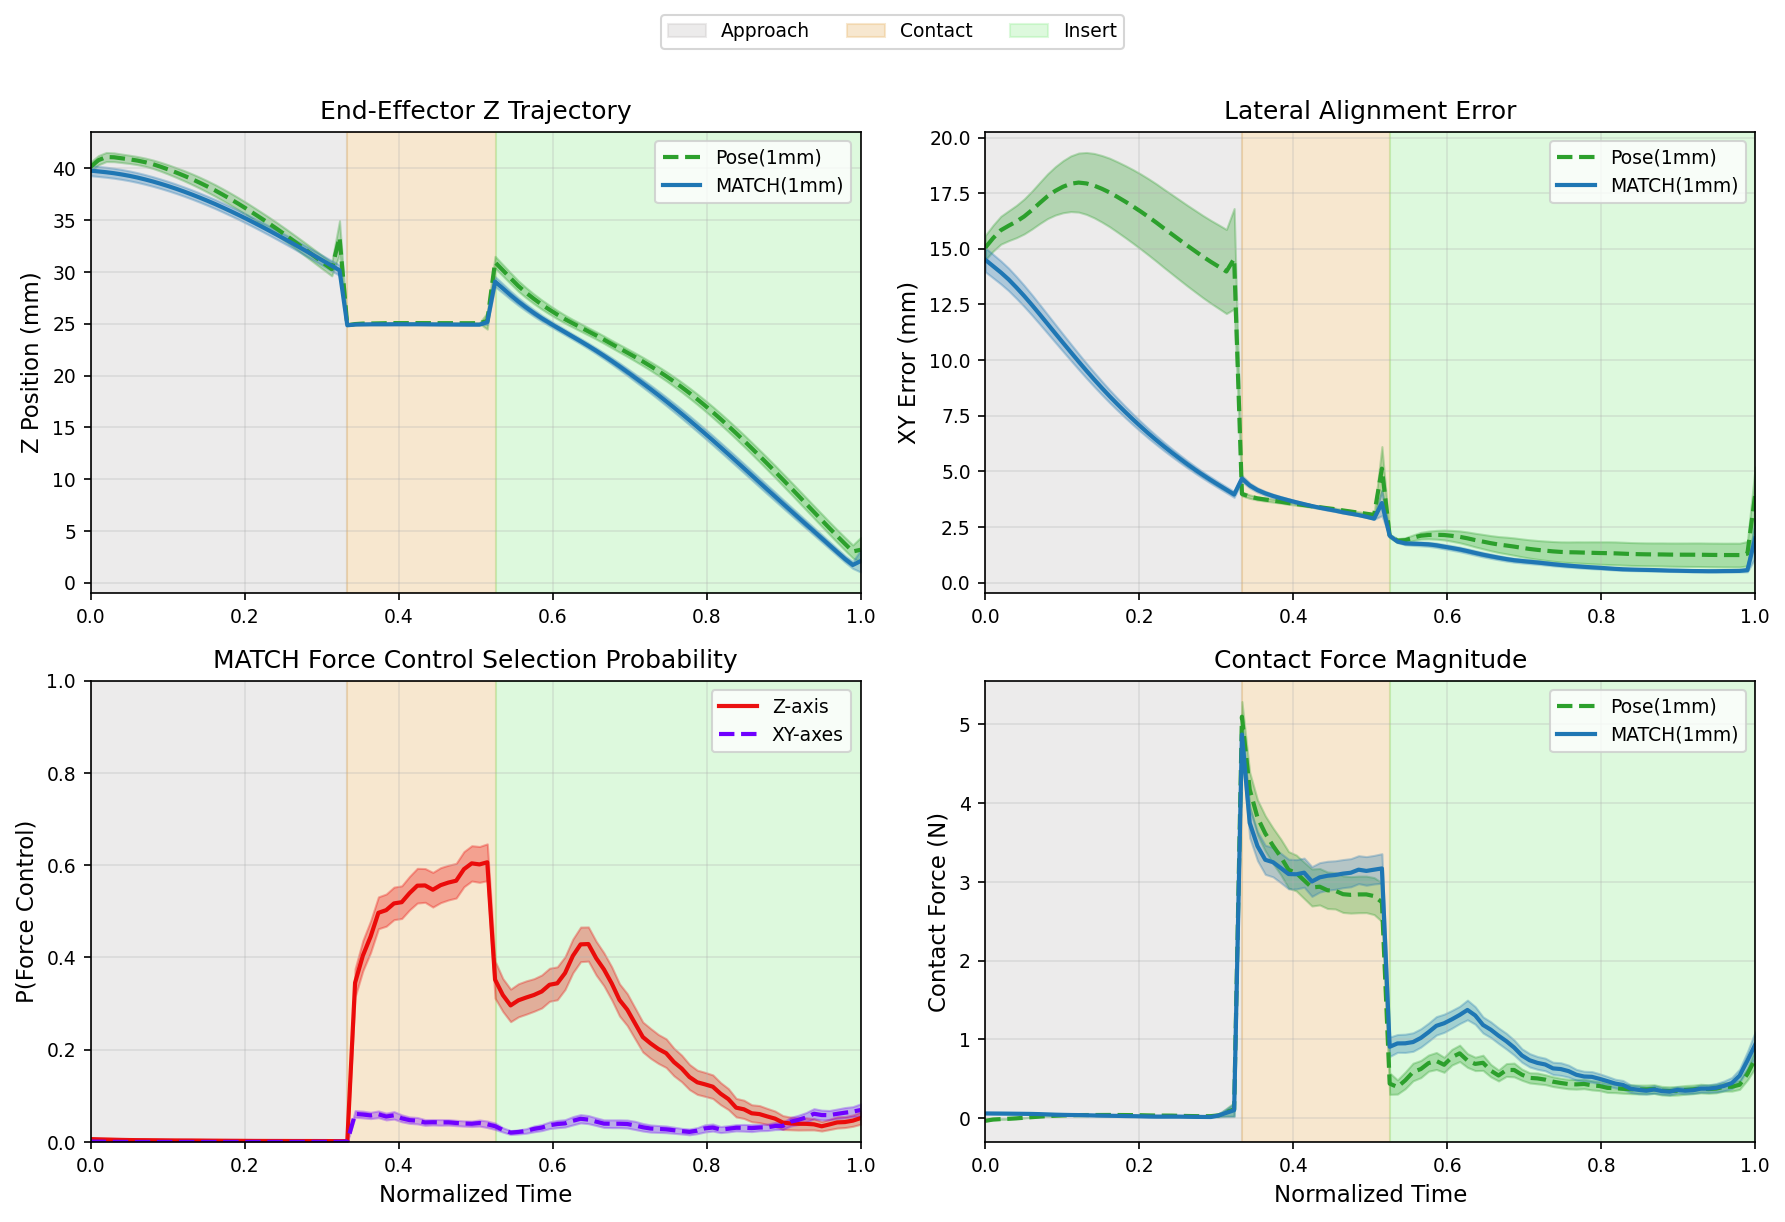

Computed phase proportions from data:
  approaching: 33.3% (avg 24.1 steps)
  initial_contact: 19.3% (avg 13.9 steps)
  insertion: 47.4% (avg 34.3 steps)


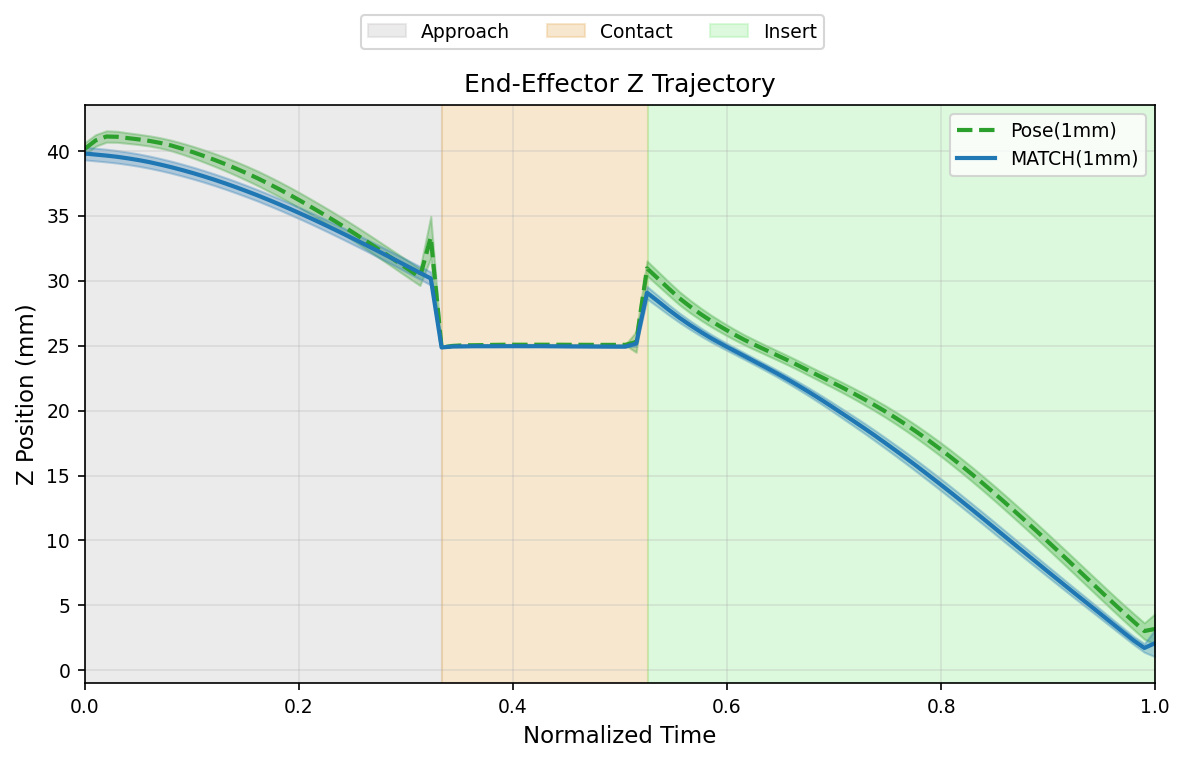

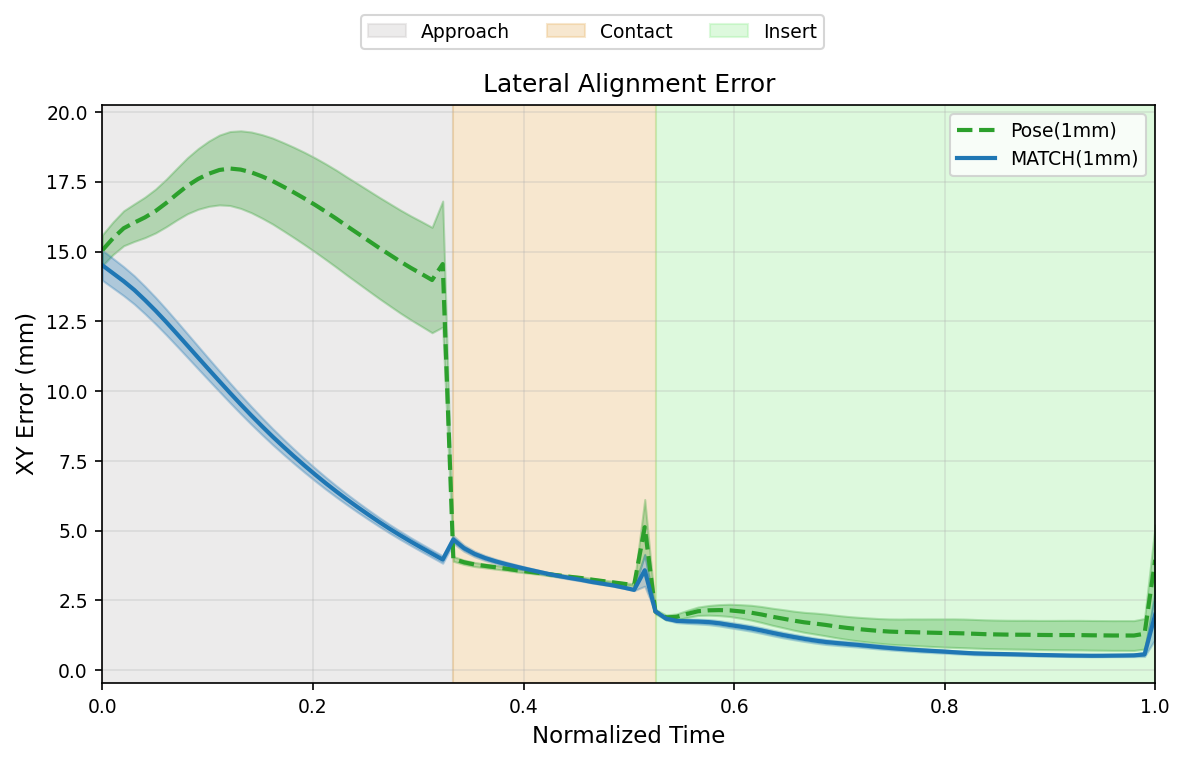

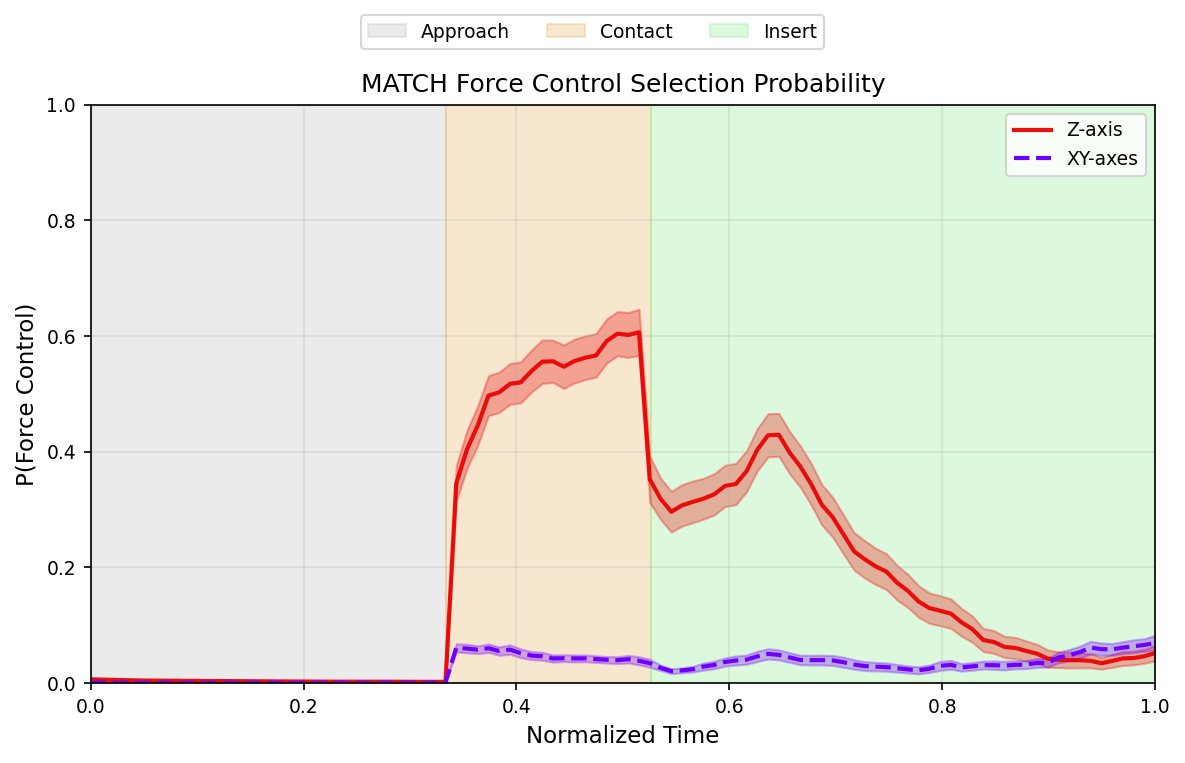

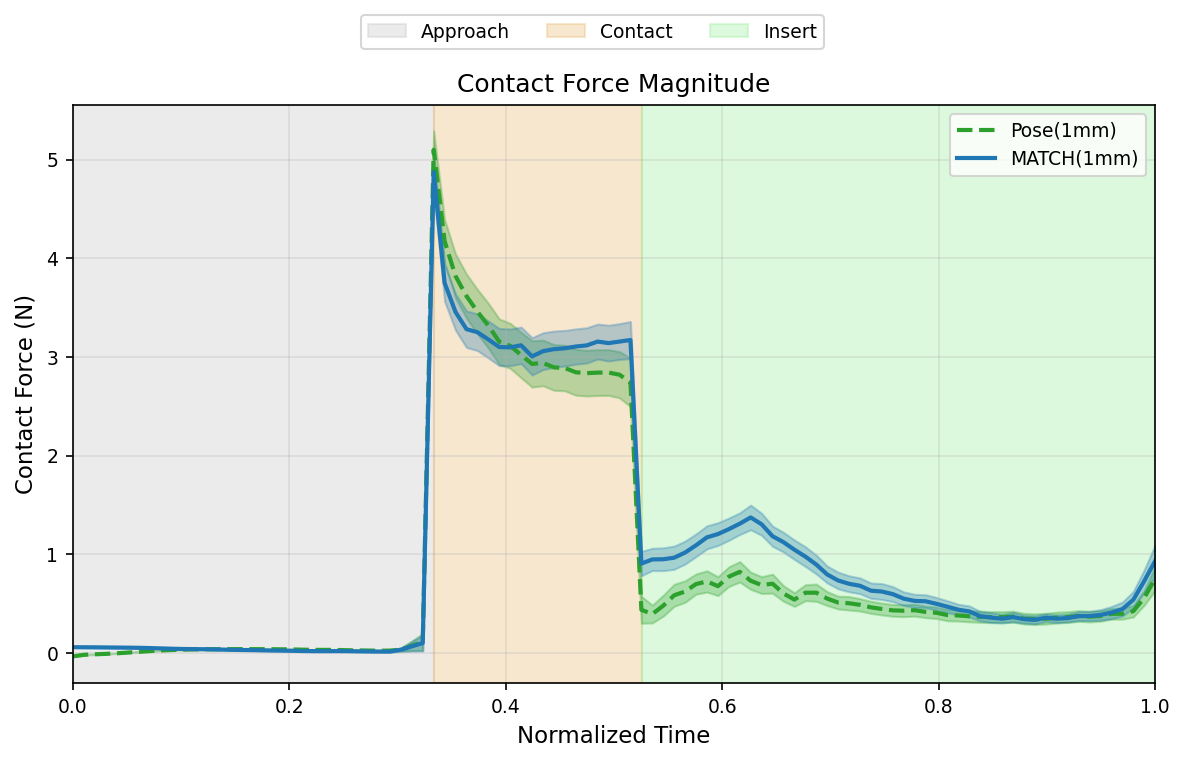

In [ ]:
# ============================================================
# BLOCK 5: MULTI-PANEL TRAJECTORY PLOT (Phase-Based Normalization)
# ============================================================
#
# Generates a 2x2 multi-panel figure with phase-based normalization:
# - Each phase is normalized separately across all trajectories
# - Phase proportions are computed from average phase lengths in the data
# - Top legend shows phase colors only
# - Each subplot has its own legend for methods

# Plot Configuration
FIGSIZE = (12, 8)
DPI = 150
N_POINTS_TOTAL = 100  # Total points across all phases
ALPHA_FILL = 0.3  # Alpha for std fill
ALPHA_PHASE = 0.3  # Alpha for phase backgrounds

# Font sizes
FONT_TITLE = 12
FONT_AXIS_LABEL = 11
FONT_TICK = 9
FONT_LEGEND = 9
FONT_SUPTITLE = 14

# Phase configuration - colors and display names (proportions computed from data)
PHASE_CONFIG = {
    'approaching': {'color': "#C2BFBF", 'display': 'Approach'},      # Gray
    'initial_contact': {'color': "#E7B262", 'display': 'Contact'},   # Light orange
    'insertion': {'color': '#90EE90', 'display': 'Insert'},          # Light green
}
PHASE_ORDER = ['approaching', 'initial_contact', 'insertion']

# Method line styles
METHOD_STYLES = {
    "Pose(1mm)": {"linestyle": "--", "linewidth": 2},
    "Hybrid-Basic": {"linestyle": "-.", "linewidth": 2},
    "MATCH(1mm)": {"linestyle": "-", "linewidth": 2},
    "LCLoP": {"linestyle": "-", "linewidth": 2},
}

# Variables to plot - with subplot titles
# 'negate': True to flip sign (for Z position and contact force)
# 'type': 'standard' for normal plot, 'selection_prob' for special selection probability plot
# 'policies': list of policies to include, or None for all
# 'ylim': optional y-axis limits
VARIABLES = [
    {'key': 'insertion_depth', 'label': 'Z Position (mm)', 'title': 'End-Effector Z Trajectory', 
     'axis': None, 'scale': 1000, 'negate': True, 'type': 'standard'},
    {'key': 'lateral_error', 'label': 'XY Error (mm)', 'title': 'Lateral Alignment Error', 
     'axis': None, 'scale': 1000, 'type': 'standard'},
    {'key': 'control_probability', 'label': 'P(Force Control)', 'title': 'MATCH Force Control Selection Probability', 
     'type': 'selection_prob', 'policies': ['MATCH(1mm)'], 'ylim': (0, 1)},
    {'key': 'contact_force', 'label': 'Contact Force (N)', 'title': 'Contact Force Magnitude', 
     'axis': 2, 'scale': 1, 'negate': True, 'type': 'standard'},
]

# Selection probability plot colors
SELECTION_PROB_COLORS = {
    'z': "#EB0101EF",      # Dark red for Z-axis
    'xy': "#6F00FF",     # Purple for XY average
}

# ============================================================

def extract_variable(step: Dict, var_config: Dict) -> Optional[float]:
    """Extract a single value from a step based on variable config."""
    key = var_config['key']
    axis = var_config.get('axis')
    scale = var_config.get('scale', 1)
    negate = var_config.get('negate', False)
    
    val = step.get(key)
    if val is None:
        return None
    
    result = None
    if axis == 'xy':
        if isinstance(val, (list, np.ndarray)) and len(val) >= 2:
            result = np.sqrt(val[0]**2 + val[1]**2) * scale
    elif axis is not None:
        if isinstance(val, (list, np.ndarray)) and len(val) > axis:
            result = val[axis] * scale
    else:
        if isinstance(val, (list, np.ndarray)):
            result = val[0] * scale if len(val) > 0 else None
        else:
            result = val * scale
    
    if result is not None and negate:
        result = -result
    
    return result


def extract_selection_prob_z(step: Dict) -> Optional[float]:
    """Extract Z-axis selection probability."""
    val = step.get('control_probability')
    if val is None:
        return None
    if isinstance(val, (list, np.ndarray)) and len(val) > 2:
        return val[2]  # Z-axis
    return None


def extract_selection_prob_xy(step: Dict) -> Optional[float]:
    """Extract average XY selection probability."""
    val = step.get('control_probability')
    if val is None:
        return None
    if isinstance(val, (list, np.ndarray)) and len(val) >= 2:
        return (val[0] + val[1]) / 2  # Average of X and Y
    return None


def compute_phase_proportions(episode_data: List[Dict]) -> Dict[str, float]:
    """
    Compute phase proportions based on average phase lengths across all episodes.
    
    Returns:
        Dict mapping phase name to proportion (sums to 1.0).
    """
    phase_lengths = defaultdict(list)
    
    for episode in episode_data:
        # Count steps per phase in this episode
        phase_counts = defaultdict(int)
        for step in episode['steps']:
            phase = step.get('phase', 'unknown')
            if phase in PHASE_CONFIG:
                phase_counts[phase] += 1
        
        # Record lengths for phases that exist in this episode
        for phase in PHASE_ORDER:
            if phase in phase_counts:
                phase_lengths[phase].append(phase_counts[phase])
    
    # Compute average length for each phase
    avg_lengths = {}
    for phase in PHASE_ORDER:
        if phase in phase_lengths and len(phase_lengths[phase]) > 0:
            avg_lengths[phase] = np.mean(phase_lengths[phase])
        else:
            avg_lengths[phase] = 0
    
    # Convert to proportions
    total_length = sum(avg_lengths.values())
    if total_length == 0:
        # Fallback to equal proportions
        n_phases = len(PHASE_ORDER)
        return {phase: 1.0 / n_phases for phase in PHASE_ORDER}
    
    proportions = {phase: length / total_length for phase, length in avg_lengths.items()}
    
    # Print computed proportions
    print("Computed phase proportions from data:")
    for phase in PHASE_ORDER:
        print(f"  {phase}: {proportions[phase]:.1%} (avg {avg_lengths[phase]:.1f} steps)")
    
    return proportions


def segment_episode_by_phase(episode: Dict) -> Dict[str, List[Dict]]:
    """
    Segment an episode's steps by phase.
    
    Returns:
        Dict mapping phase name to list of steps in that phase.
    """
    segments = defaultdict(list)
    
    for step in episode['steps']:
        phase = step.get('phase', 'unknown')
        if phase in PHASE_CONFIG:
            segments[phase].append(step)
    
    return segments


def normalize_phase_segments(
    episodes_by_policy: Dict[str, List[Dict]],
    var_config: Dict,
    phase_proportions: Dict[str, float],
    n_points_total: int = 100
) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Normalize trajectories by phase and compute mean/std for each policy.
    
    Each phase is normalized to its allocated proportion of the total points.
    
    Returns:
        Dict mapping policy name to (t, mean, std) arrays for the full normalized trajectory.
    """
    # Calculate points per phase based on proportions
    points_per_phase = {}
    for phase in PHASE_ORDER:
        points_per_phase[phase] = max(1, int(n_points_total * phase_proportions.get(phase, 0)))
    
    # Adjust to ensure total is exactly n_points_total
    total_points = sum(points_per_phase.values())
    diff = n_points_total - total_points
    if diff != 0:
        # Add/subtract from the largest phase
        largest_phase = max(points_per_phase, key=points_per_phase.get)
        points_per_phase[largest_phase] += diff
    
    # Build time axis
    t_full = np.linspace(0, 1, n_points_total)
    
    results = {}
    
    for policy, episodes in episodes_by_policy.items():
        all_trajectories = []
        
        for episode in episodes:
            segments = segment_episode_by_phase(episode)
            
            # Build normalized trajectory for this episode
            trajectory_parts = []
            
            for phase in PHASE_ORDER:
                n_points = points_per_phase.get(phase, 0)
                if n_points == 0:
                    continue
                
                if phase in segments and len(segments[phase]) > 0:
                    # Extract values for this phase
                    values = []
                    for step in segments[phase]:
                        val = extract_variable(step, var_config)
                        values.append(val if val is not None else np.nan)
                    
                    if len(values) > 1:
                        # Interpolate to allocated points
                        t_orig = np.linspace(0, 1, len(values))
                        t_target = np.linspace(0, 1, n_points)
                        interpolated = np.interp(t_target, t_orig, values)
                        trajectory_parts.append(interpolated)
                    elif len(values) == 1:
                        # Single point - repeat
                        trajectory_parts.append(np.full(n_points, values[0]))
                    else:
                        trajectory_parts.append(np.full(n_points, np.nan))
                else:
                    # Phase not present - fill with NaN
                    trajectory_parts.append(np.full(n_points, np.nan))
            
            if trajectory_parts:
                full_trajectory = np.concatenate(trajectory_parts)
                if len(full_trajectory) == n_points_total:
                    all_trajectories.append(full_trajectory)
        
        if all_trajectories:
            trajectories = np.array(all_trajectories)
            n = len(all_trajectories)
            with np.errstate(all='ignore'):
                mean = np.nanmean(trajectories, axis=0)
                std = np.nanstd(trajectories, axis=0)
            results[policy] = (t_full, mean, std, n)
    
    return results


def normalize_selection_prob_segments(
    episodes_by_policy: Dict[str, List[Dict]],
    extract_func,
    phase_proportions: Dict[str, float],
    n_points_total: int = 100
) -> Dict[str, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
    """
    Normalize selection probability trajectories by phase.
    
    Similar to normalize_phase_segments but uses a custom extraction function.
    """
    # Calculate points per phase based on proportions
    points_per_phase = {}
    for phase in PHASE_ORDER:
        points_per_phase[phase] = max(1, int(n_points_total * phase_proportions.get(phase, 0)))
    
    # Adjust to ensure total is exactly n_points_total
    total_points = sum(points_per_phase.values())
    diff = n_points_total - total_points
    if diff != 0:
        largest_phase = max(points_per_phase, key=points_per_phase.get)
        points_per_phase[largest_phase] += diff
    
    # Build time axis
    t_full = np.linspace(0, 1, n_points_total)
    
    results = {}
    
    for policy, episodes in episodes_by_policy.items():
        all_trajectories = []
        
        for episode in episodes:
            segments = segment_episode_by_phase(episode)
            trajectory_parts = []
            
            for phase in PHASE_ORDER:
                n_points = points_per_phase.get(phase, 0)
                if n_points == 0:
                    continue
                
                if phase in segments and len(segments[phase]) > 0:
                    values = []
                    for step in segments[phase]:
                        val = extract_func(step)
                        values.append(val if val is not None else np.nan)
                    
                    if len(values) > 1:
                        t_orig = np.linspace(0, 1, len(values))
                        t_target = np.linspace(0, 1, n_points)
                        interpolated = np.interp(t_target, t_orig, values)
                        trajectory_parts.append(interpolated)
                    elif len(values) == 1:
                        trajectory_parts.append(np.full(n_points, values[0]))
                    else:
                        trajectory_parts.append(np.full(n_points, np.nan))
                else:
                    trajectory_parts.append(np.full(n_points, np.nan))
            
            if trajectory_parts:
                full_trajectory = np.concatenate(trajectory_parts)
                if len(full_trajectory) == n_points_total:
                    all_trajectories.append(full_trajectory)
        
        if all_trajectories:
            trajectories = np.array(all_trajectories)
            n = len(all_trajectories)
            with np.errstate(all='ignore'):
                mean = np.nanmean(trajectories, axis=0)
                std = np.nanstd(trajectories, axis=0)
            results[policy] = (t_full, mean, std, n)
    
    return results


def get_phase_boundaries(phase_proportions: Dict[str, float]) -> List[Tuple[float, float, str]]:
    """
    Get phase boundaries as (start, end, phase_name) tuples in normalized coordinates.
    """
    boundaries = []
    cumulative = 0.0
    
    for phase in PHASE_ORDER:
        proportion = phase_proportions.get(phase, 0)
        if proportion > 0:
            start = cumulative
            end = cumulative + proportion
            boundaries.append((start, end, phase))
            cumulative = end
    
    return boundaries


def plot_trajectory_multipanel(
    episode_data: List[Dict],
    variables: List[Dict],
    n_points: int = 100,
    figsize: Tuple[float, float] = (12, 8)
) -> plt.Figure:
    """
    Create 2x2 multi-panel trajectory plot with phase-based normalization.
    """
    n_vars = len(variables)
    n_rows = 2
    n_cols = 2
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, dpi=DPI)
    axes_flat = axes.flatten()
    
    # Compute phase proportions from data
    phase_proportions = compute_phase_proportions(episode_data)
    
    # Group episodes by policy
    episodes_by_policy = defaultdict(list)
    for ep in episode_data:
        episodes_by_policy[ep['policy']].append(ep)
    
    # Get phase boundaries
    phase_boundaries = get_phase_boundaries(phase_proportions)
    
    for ax_idx, var_config in enumerate(variables):
        if ax_idx >= len(axes_flat):
            break
        ax = axes_flat[ax_idx]
        
        # Draw phase backgrounds
        for start, end, phase in phase_boundaries:
            if phase in PHASE_CONFIG:
                ax.axvspan(start, end, alpha=ALPHA_PHASE, color=PHASE_CONFIG[phase]['color'])
        
        plot_type = var_config.get('type', 'standard')
        allowed_policies = var_config.get('policies', None)
        
        if plot_type == 'selection_prob':
            # Special handling for selection probability plot
            # Filter to allowed policies
            filtered_episodes = {p: eps for p, eps in episodes_by_policy.items() 
                               if allowed_policies is None or p in allowed_policies}
            
            # Plot Z-axis probability
            z_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_z, 
                                                        phase_proportions, n_points)
            for policy, (t, mean, std, n) in z_data.items():
                ci = 1.96 * std / np.sqrt(n)
                ax.plot(t, mean, color=SELECTION_PROB_COLORS['z'], linestyle='-', 
                       linewidth=2, label='Z-axis')
                ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['z'], 
                               alpha=ALPHA_FILL)
            
            # Plot XY average probability
            xy_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_xy,
                                                         phase_proportions, n_points)
            for policy, (t, mean, std, n) in xy_data.items():
                ci = 1.96 * std / np.sqrt(n)
                ax.plot(t, mean, color=SELECTION_PROB_COLORS['xy'], linestyle='--', 
                       linewidth=2, label='XY-axes')
                ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['xy'], 
                               alpha=ALPHA_FILL)
        else:
            # Standard plot - compute normalized trajectories for this variable
            policy_data = normalize_phase_segments(episodes_by_policy, var_config, 
                                                   phase_proportions, n_points)
            
            # Filter to allowed policies if specified
            if allowed_policies is not None:
                policy_data = {p: data for p, data in policy_data.items() if p in allowed_policies}
            
            # Plot each policy
            for policy, (t, mean, std, n) in policy_data.items():
                ci = 1.96 * std / np.sqrt(n)
                color = METHOD_COLORS.get(policy, 'gray')
                style = METHOD_STYLES.get(policy, {"linestyle": "-", "linewidth": 2})
                
                ax.plot(t, mean, color=color, label=policy, **style)
                ax.fill_between(t, mean - ci, mean + ci, color=color, alpha=ALPHA_FILL)
        
        # Configure subplot
        ax.set_title(var_config.get('title', var_config['label']), fontsize=FONT_TITLE)
        ax.set_ylabel(var_config['label'], fontsize=FONT_AXIS_LABEL)
        ax.tick_params(labelsize=FONT_TICK)
        ax.grid(True, alpha=0.3)
        ax.set_xlim(0, 1)
        
        # Set y-limits if specified
        if 'ylim' in var_config:
            ax.set_ylim(var_config['ylim'])
        
        # X-axis label on bottom row only
        row = ax_idx // n_cols
        if row == n_rows - 1:
            ax.set_xlabel('Normalized Time', fontsize=FONT_AXIS_LABEL)
        
        # Per-subplot legend for methods
        ax.legend(fontsize=FONT_LEGEND, loc='best')
    
    # Hide unused subplots
    for idx in range(n_vars, len(axes_flat)):
        axes_flat[idx].set_visible(False)
    
    # Create top legend for phases only
    phase_handles = []
    phase_labels = []
    for phase in PHASE_ORDER:
        if phase in PHASE_CONFIG:
            phase_handles.append(mpatches.Patch(color=PHASE_CONFIG[phase]['color'], alpha=ALPHA_PHASE))
            phase_labels.append(PHASE_CONFIG[phase]['display'])
    
    fig.legend(phase_handles, phase_labels, loc='upper center', ncol=len(phase_handles), 
               fontsize=FONT_LEGEND, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_trajectory_multipanel(
        all_episode_data,
        VARIABLES,
        n_points=N_POINTS_TOTAL,
        figsize=FIGSIZE
    )
    plt.show()
else:
    print("No episode data loaded. Please run trajectory evaluation first.")



def plot_trajectory_single(
    episode_data: List[Dict],
    var_config: Dict,
    phase_proportions: Dict[str, float],
    n_points: int = 100,
    figsize: Tuple[float, float] = (8, 5)
) -> plt.Figure:
    """
    Create a single trajectory plot for one variable with phase-based normalization.
    """
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    # Group episodes by policy
    episodes_by_policy = defaultdict(list)
    for ep in episode_data:
        episodes_by_policy[ep['policy']].append(ep)
    
    # Get phase boundaries
    phase_boundaries = get_phase_boundaries(phase_proportions)
    
    # Draw phase backgrounds
    for start, end, phase in phase_boundaries:
        if phase in PHASE_CONFIG:
            ax.axvspan(start, end, alpha=ALPHA_PHASE, color=PHASE_CONFIG[phase]['color'])
    
    plot_type = var_config.get('type', 'standard')
    allowed_policies = var_config.get('policies', None)
    
    if plot_type == 'selection_prob':
        # Special handling for selection probability plot
        filtered_episodes = {p: eps for p, eps in episodes_by_policy.items() 
                           if allowed_policies is None or p in allowed_policies}
        
        # Plot Z-axis probability
        z_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_z, 
                                                    phase_proportions, n_points)
        for policy, (t, mean, std, n) in z_data.items():
            ci = 1.96 * std / np.sqrt(n)
            ax.plot(t, mean, color=SELECTION_PROB_COLORS['z'], linestyle='-', 
                   linewidth=2, label='Z-axis')
            ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['z'], 
                           alpha=ALPHA_FILL)
        
        # Plot XY average probability
        xy_data = normalize_selection_prob_segments(filtered_episodes, extract_selection_prob_xy,
                                                     phase_proportions, n_points)
        for policy, (t, mean, std, n) in xy_data.items():
            ci = 1.96 * std / np.sqrt(n)
            ax.plot(t, mean, color=SELECTION_PROB_COLORS['xy'], linestyle='--', 
                   linewidth=2, label='XY-axes')
            ax.fill_between(t, mean - ci, mean + ci, color=SELECTION_PROB_COLORS['xy'], 
                           alpha=ALPHA_FILL)
    else:
        # Standard plot
        policy_data = normalize_phase_segments(episodes_by_policy, var_config, 
                                               phase_proportions, n_points)
        
        if allowed_policies is not None:
            policy_data = {p: data for p, data in policy_data.items() if p in allowed_policies}
        
        for policy, (t, mean, std, n) in policy_data.items():
            ci = 1.96 * std / np.sqrt(n)
            color = METHOD_COLORS.get(policy, 'gray')
            style = METHOD_STYLES.get(policy, {"linestyle": "-", "linewidth": 2})
            
            ax.plot(t, mean, color=color, label=policy, **style)
            ax.fill_between(t, mean - ci, mean + ci, color=color, alpha=ALPHA_FILL)
    
    # Configure plot
    ax.set_title(var_config.get('title', var_config['label']), fontsize=FONT_TITLE)
    ax.set_ylabel(var_config['label'], fontsize=FONT_AXIS_LABEL)
    ax.set_xlabel('Normalized Time', fontsize=FONT_AXIS_LABEL)
    ax.tick_params(labelsize=FONT_TICK)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(0, 1)
    
    if 'ylim' in var_config:
        ax.set_ylim(var_config['ylim'])
    
    # Methods legend
    ax.legend(fontsize=FONT_LEGEND, loc='best')
    
    # Phase legend at top
    phase_handles = []
    phase_labels = []
    for phase in PHASE_ORDER:
        if phase in PHASE_CONFIG:
            phase_handles.append(mpatches.Patch(color=PHASE_CONFIG[phase]['color'], alpha=ALPHA_PHASE))
            phase_labels.append(PHASE_CONFIG[phase]['display'])
    
    fig.legend(phase_handles, phase_labels, loc='upper center', ncol=len(phase_handles), 
               fontsize=FONT_LEGEND, bbox_to_anchor=(0.5, 1.02))
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig


# Generate individual plots for each variable
if all_episode_data:
    # Compute phase proportions once for all plots
    phase_proportions_single = compute_phase_proportions(all_episode_data)
    
    for var_config in VARIABLES:
        fig = plot_trajectory_single(
            all_episode_data,
            var_config,
            phase_proportions_single,
            n_points=N_POINTS_TOTAL,
            figsize=(8, 5)
        )
        plt.show()

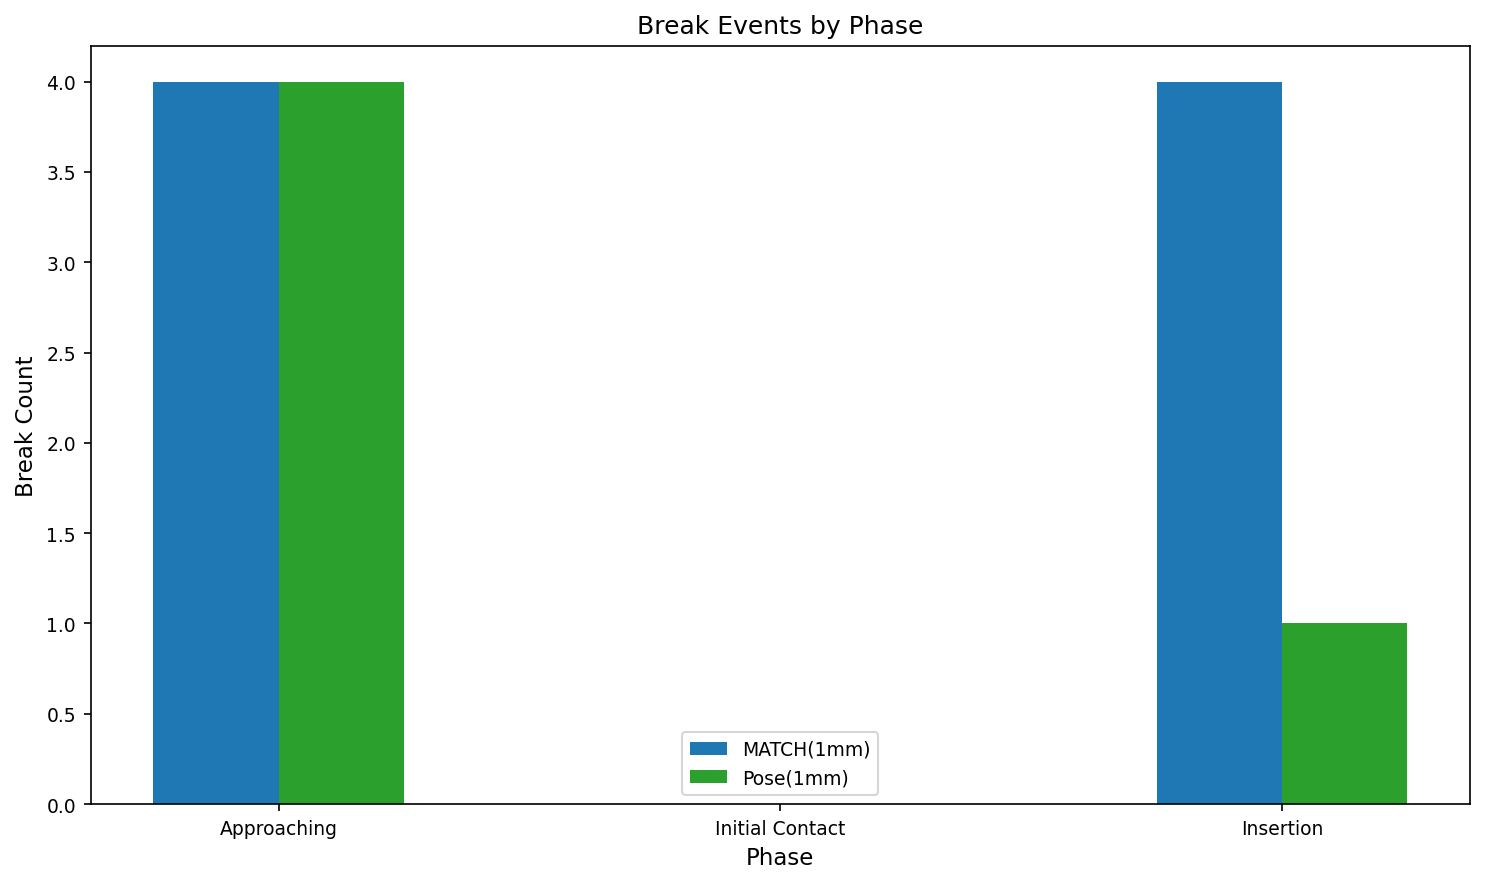

In [ ]:
# ============================================================
# BLOCK 6: BREAKS BY PHASE
# ============================================================
#
# Bar chart showing the number of break events that occurred
# during each phase, grouped by policy.

# Plot Configuration
FIGSIZE_BREAKS = (10, 6)
BAR_WIDTH = 0.25

# ============================================================

def plot_break_count_by_phase(
    episode_data: List[Dict],
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Bar chart of break counts by phase, grouped by policy.
    """
    # Extract phase at termination for break episodes
    break_phases = defaultdict(lambda: defaultdict(int))
    
    for ep in episode_data:
        if ep['outcome'] == 'break':
            policy = ep['policy']
            # Find the last step (where break occurred)
            if ep['steps']:
                last_step = ep['steps'][-1]
                phase = last_step.get('phase', 'unknown')
                break_phases[policy][phase] += 1
    
    if not break_phases:
        print("No break events found in data.")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    policies = sorted(break_phases.keys())
    x = np.arange(len(PHASES))
    width = BAR_WIDTH
    
    for i, policy in enumerate(policies):
        counts = [break_phases[policy][phase] for phase in PHASES]
        offset = (i - len(policies)/2 + 0.5) * width
        color = METHOD_COLORS.get(policy, 'gray')
        ax.bar(x + offset, counts, width, label=policy, color=color)
    
    ax.set_xlabel('Phase', fontsize=FONT_AXIS_LABEL)
    ax.set_ylabel('Break Count', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Break Events by Phase', fontsize=FONT_TITLE)
    ax.set_xticks(x)
    ax.set_xticklabels([p.replace('_', ' ').title() for p in PHASES], fontsize=FONT_TICK)
    ax.legend(fontsize=FONT_LEGEND)
    ax.tick_params(labelsize=FONT_TICK)
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_break_count_by_phase(all_episode_data, figsize=FIGSIZE_BREAKS)
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

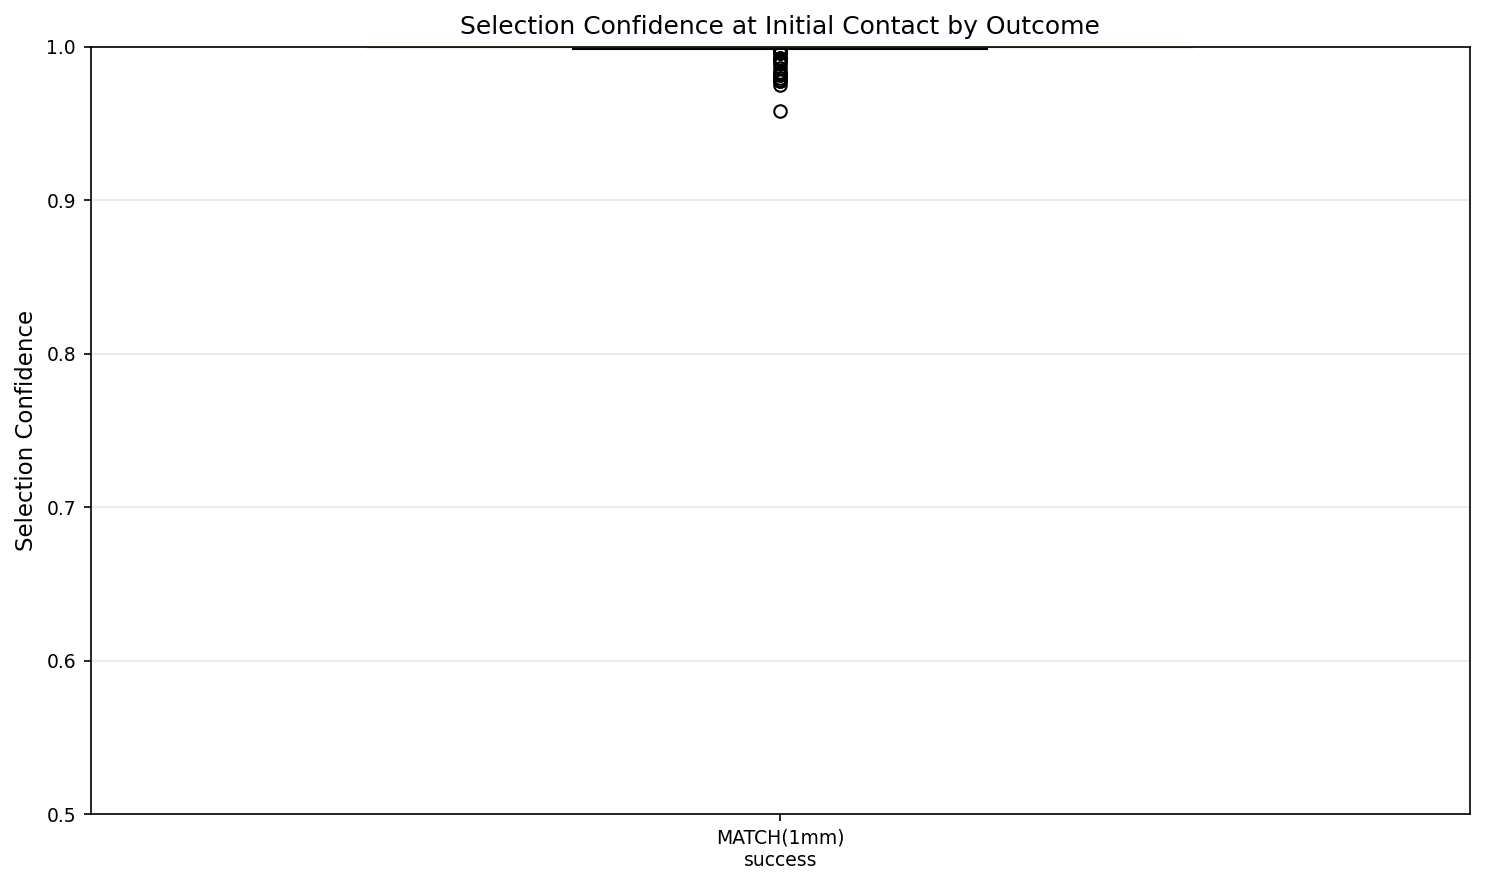

In [ ]:
# ============================================================
# BLOCK 7: SELECTION CONFIDENCE COMPARISON
# ============================================================
#
# Compares selection confidence (max probability across modes)
# at the moment of initial contact, separated by outcome.
# Higher confidence may correlate with better outcomes.

# Plot Configuration
FIGSIZE_CONFIDENCE = (10, 6)
CONFIDENCE_AXIS = 2  # Z-axis for insertion

# ============================================================

def plot_selection_confidence_at_contact(
    episode_data: List[Dict],
    axis: int = 2,
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Box plot of selection confidence at initial contact, by outcome.
    
    Selection confidence = max(p, 1-p) where p is the selection probability.
    This measures how "certain" the policy is about its mode choice.
    """
    # Collect confidence at contact for each policy and outcome
    data = defaultdict(lambda: defaultdict(list))
    
    for ep in episode_data:
        policy = ep['policy']
        outcome = ep['outcome']
        
        # Find first step in initial_contact phase
        for step in ep['steps']:
            if step.get('phase') == 'initial_contact':
                prob = step.get('control_probability')
                if prob is not None and len(prob) > axis:
                    p = prob[axis]
                    confidence = max(p, 1 - p)
                    data[policy][outcome].append(confidence)
                break
    
    if not data:
        print("No selection confidence data found.")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    policies = sorted(data.keys())
    outcomes_present = ['success', 'break']  # Focus on these
    
    positions = []
    labels = []
    box_data = []
    colors = []
    
    pos = 0
    for policy in policies:
        for outcome in outcomes_present:
            if data[policy][outcome]:
                box_data.append(data[policy][outcome])
                positions.append(pos)
                labels.append(f"{policy}\n{outcome}")
                colors.append(METHOD_COLORS.get(policy, 'gray'))
                pos += 1
        pos += 0.5  # Gap between policies
    
    bp = ax.boxplot(box_data, positions=positions, patch_artist=True, widths=0.6)
    
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    ax.set_xticks(positions)
    ax.set_xticklabels(labels, fontsize=FONT_TICK)
    ax.set_ylabel('Selection Confidence', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Selection Confidence at Initial Contact by Outcome', fontsize=FONT_TITLE)
    ax.set_ylim(0.5, 1.0)  # Confidence ranges from 0.5 to 1.0
    ax.tick_params(labelsize=FONT_TICK)
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_selection_confidence_at_contact(
        all_episode_data,
        axis=CONFIDENCE_AXIS,
        figsize=FIGSIZE_CONFIDENCE
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

In [ ]:
# ============================================================
# BLOCK 8: SELECTION PROBABILITY TRAJECTORIES BY PHASE
# ============================================================
#
# Shows how selection probability (force vs position control)
# evolves within each phase, separated by outcome.
# Includes both LCLoP and Hybrid-Basic policies.

# Plot Configuration
FIGSIZE_PROB_TRAJ = (14, 8)  # Taller to accommodate two rows
PROB_AXIS = 2  # Z-axis
NUM_BINS = 20  # Normalized time bins per phase

# Outcome colors
OUTCOME_COLORS = {
    'success': '#2ca02c',  # Green
    'break': '#d62728',    # Red
    'timeout': '#7f7f7f',  # Gray
}

# Policies with selection probability
HYBRID_POLICIES = ['SWISH', 'LCLoP', 'Hybrid-Basic']

# ============================================================

def plot_selection_probability_by_phase_trajectory(
    episode_data: List[Dict],
    axis: int = 2,
    num_bins: int = 20,
    figsize: Tuple[float, float] = (14, 8)
) -> plt.Figure:
    """
    Plot selection probability trajectories normalized within each phase.
    Shows mean ± std for success vs break outcomes.
    Includes both LCLoP and Hybrid-Basic policies.
    """
    # Filter to policies with selection probability
    hybrid_episodes = [ep for ep in episode_data if ep['policy'] in HYBRID_POLICIES]
    
    if not hybrid_episodes:
        print("No LCLoP or Hybrid-Basic episodes found.")
        return None
    
    # Group by policy
    episodes_by_policy = defaultdict(list)
    for ep in hybrid_episodes:
        episodes_by_policy[ep['policy']].append(ep)
    
    # Create 2-row figure: one row per policy
    policies_present = [p for p in HYBRID_POLICIES if p in episodes_by_policy]
    n_policies = len(policies_present)
    
    fig, axes = plt.subplots(n_policies, len(PHASES), figsize=figsize, dpi=DPI, sharey=True)
    if n_policies == 1:
        axes = axes.reshape(1, -1)
    
    for row_idx, policy in enumerate(policies_present):
        policy_episodes = episodes_by_policy[policy]
        
        # Collect trajectories: {phase: {outcome: [[prob_at_normalized_time]]}}
        trajectories = {phase: {outcome: [] for outcome in ['success', 'break']} for phase in PHASES}
        
        for ep in policy_episodes:
            outcome = ep['outcome']
            if outcome not in ['success', 'break']:
                continue
            
            # Group steps by phase
            phase_steps = defaultdict(list)
            for step in ep['steps']:
                phase_steps[step.get('phase', 'unknown')].append(step)
            
            # Extract normalized trajectory for each phase
            for phase in PHASES:
                steps = phase_steps.get(phase, [])
                if len(steps) < 2:
                    continue
                
                probs = []
                for step in steps:
                    prob = step.get('control_probability')
                    if prob is not None and len(prob) > axis:
                        probs.append(prob[axis])
                    else:
                        probs.append(np.nan)
                
                # Interpolate to fixed number of bins
                t_orig = np.linspace(0, 1, len(probs))
                t_new = np.linspace(0, 1, num_bins)
                normalized = np.interp(t_new, t_orig, probs)
                trajectories[phase][outcome].append(normalized)
        
        t_norm = np.linspace(0, 100, num_bins)
        
        for col_idx, phase in enumerate(PHASES):
            ax = axes[row_idx, col_idx]
            
            # Add phase background
            ax.axvspan(0, 100, alpha=0.15, color=PHASE_COLORS[phase])
            
            for outcome in ['success', 'break']:
                trajs = trajectories[phase][outcome]
                if not trajs:
                    continue
                
                trajs = np.array(trajs)
                with np.errstate(all='ignore'):
                    mean = np.nanmean(trajs, axis=0)
                    std = np.nanstd(trajs, axis=0)
                
                color = OUTCOME_COLORS[outcome]
                ax.plot(t_norm, mean, color=color, linewidth=2, label=outcome.title())
                ax.fill_between(t_norm, mean - std, mean + std, color=color, alpha=ALPHA_FILL)
            
            ax.set_xlabel('Phase Progress (%)', fontsize=FONT_AXIS_LABEL)
            ax.tick_params(labelsize=FONT_TICK)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(0, 1)
            
            # Column titles (phase names) only on top row
            if row_idx == 0:
                ax.set_title(phase.replace('_', ' ').title(), fontsize=FONT_TITLE)
            
            # Row labels (policy names) only on first column
            if col_idx == 0:
                ax.set_ylabel(f'{policy}\nForce Control Prob', fontsize=FONT_AXIS_LABEL)
                ax.legend(fontsize=FONT_LEGEND, loc='upper left')
    
    plt.suptitle('Selection Probability Trajectory by Phase', fontsize=FONT_TITLE, y=1.02)
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_selection_probability_by_phase_trajectory(
        all_episode_data,
        axis=PROB_AXIS,
        num_bins=NUM_BINS,
        figsize=FIGSIZE_PROB_TRAJ
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

No LCLoP or Hybrid-Basic episodes found.


In [ ]:
# ============================================================
# BLOCK 9: SELECTION PROBABILITY BY PHASE (VIOLIN PLOT)
# ============================================================
#
# Violin plots showing distribution of selection probability
# values within each phase, comparing success vs break outcomes.

# Plot Configuration
FIGSIZE_VIOLIN = (10, 6)

# ============================================================

def plot_selection_probability_by_phase_violin(
    episode_data: List[Dict],
    axis: int = 2,
    figsize: Tuple[float, float] = (10, 6)
) -> plt.Figure:
    """
    Violin plots of selection probability by phase, comparing outcomes.
    """
    import seaborn as sns
    
    # Filter to LCLoP only
    lclop_episodes = [ep for ep in episode_data if ep['policy'] == 'SWISH']
    
    if not lclop_episodes:
        print("No LCLoP episodes found.")
        return None
    
    # Collect data
    data = defaultdict(lambda: defaultdict(list))
    
    for ep in lclop_episodes:
        outcome = ep['outcome']
        if outcome not in ['success', 'break']:
            continue
        
        for step in ep['steps']:
            phase = step.get('phase', 'unknown')
            prob = step.get('control_probability')
            if prob is not None and len(prob) > axis and phase in PHASES:
                data[phase][outcome].append(prob[axis])
    
    # Build DataFrame
    rows = []
    for phase in PHASES:
        for outcome in ['success', 'break']:
            for prob in data[phase][outcome]:
                rows.append({
                    'Phase': phase.replace('_', ' ').title(),
                    'Outcome': outcome.title(),
                    'Probability': prob
                })
    
    if not rows:
        print("No data to plot.")
        return None
    
    df = pd.DataFrame(rows)
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    phase_order = [p.replace('_', ' ').title() for p in PHASES]
    
    sns.violinplot(
        data=df, x='Phase', y='Probability', hue='Outcome',
        order=phase_order, split=True, ax=ax,
        palette={'Success': OUTCOME_COLORS['success'], 'Break': OUTCOME_COLORS['break']}
    )
    
    ax.set_xlabel('Phase', fontsize=FONT_AXIS_LABEL)
    ax.set_ylabel('Force Control Probability', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Selection Probability Distribution by Phase and Outcome (LCLoP)', fontsize=FONT_TITLE)
    ax.tick_params(labelsize=FONT_TICK)
    ax.legend(fontsize=FONT_LEGEND)
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    try:
        fig = plot_selection_probability_by_phase_violin(
            all_episode_data,
            axis=PROB_AXIS,
            figsize=FIGSIZE_VIOLIN
        )
        if fig:
            plt.show()
    except ImportError:
        print("Seaborn not installed. Install with: pip install seaborn")
else:
    print("No episode data loaded.")

No LCLoP episodes found.


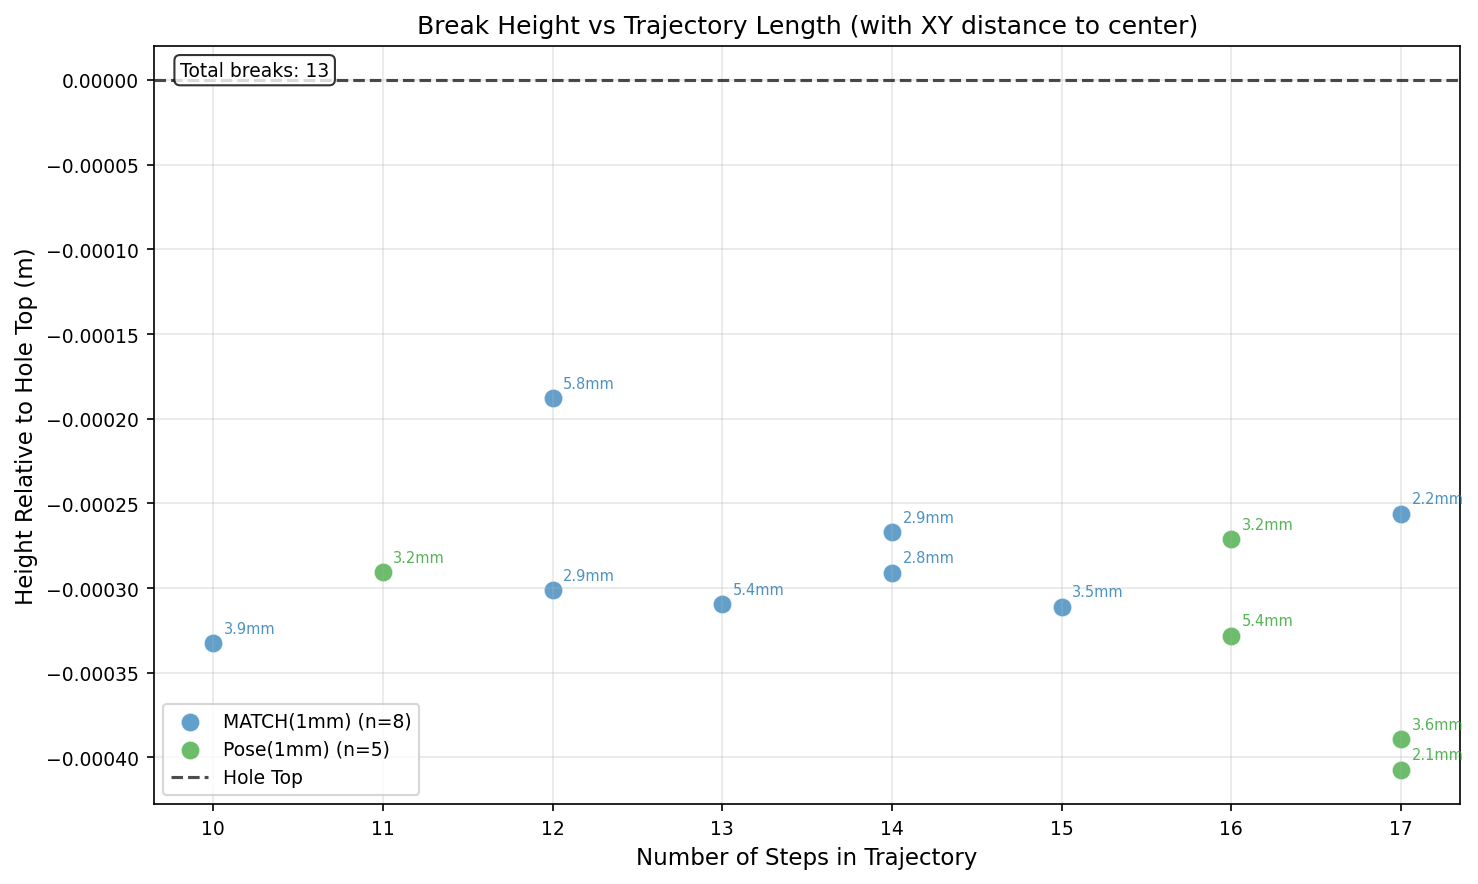

In [ ]:
# ============================================================
# BLOCK 10: BREAK DEPTH VS TRAJECTORY LENGTH
# ============================================================
#
# Scatter plot showing for each break event:
# - X-axis: Number of steps in the trajectory before break occurred
# - Y-axis: Height relative to top of hole (0 = top, negative = inserted)
# - Text annotation: XY distance to hole center (mm)
#
# Height is computed as: peg_z - hole_z - HOLE_DEPTH
# So that 0 = top of hole, -HOLE_DEPTH = bottom (success)

# Plot Configuration
FIGSIZE_BREAK_SCATTER = (10, 6)
MARKER_SIZE = 80
MARKER_ALPHA = 0.7

# Hole depth in meters (2.5cm)
HOLE_DEPTH = 0.025

# ============================================================

def plot_break_depth_vs_steps(episode_data, hole_depth=0.025, figsize=(10, 6)):
    """
    Scatter plot of break height vs number of steps in trajectory.
    
    Height is computed as: peg_z - hole_z - hole_depth
    - Positive: peg is above the hole top (approach phase)
    - Zero: peg is at the top of the hole
    - Negative: peg is inside the hole (insertion phase)
    - -hole_depth: peg is at the bottom (success)
    
    Also shows XY distance to hole center as text annotation.
    
    Args:
        episode_data: List of episode dicts
        hole_depth: Depth of the hole in meters (default 0.025m = 2.5cm)
        figsize: Figure size
        
    Returns:
        matplotlib Figure
    """
    # Collect data for break episodes
    break_data = defaultdict(lambda: {'steps': [], 'heights': [], 'xy_dists': []})
    
    for ep in episode_data:
        if ep['outcome'] != 'break':
            continue
        
        policy = ep['policy']
        steps = ep['steps']
        hole_pos = ep.get('hole_pos')
        
        if not steps or hole_pos is None:
            continue
        
        # Number of steps in trajectory
        n_steps = len(steps)
        
        # Get peg position at break (last step)
        last_step = steps[-1]
        peg_pos = last_step.get('peg_pos')
        
        if peg_pos is None or len(peg_pos) < 3:
            continue
        
        # Compute height relative to top of hole
        # peg_z - hole_z - hole_depth
        # 0 = at top of hole, negative = inserted, -hole_depth = bottom
        height = peg_pos[2] - hole_pos[2] - hole_depth
        
        # Compute XY distance to hole center
        xy_dist = np.sqrt((peg_pos[0] - hole_pos[0])**2 + (peg_pos[1] - hole_pos[1])**2)
        
        break_data[policy]['steps'].append(n_steps)
        break_data[policy]['heights'].append(height)
        break_data[policy]['xy_dists'].append(xy_dist)
    
    if not any(break_data[p]['steps'] for p in break_data):
        print("No break events with valid height data found.")
        return None
    
    # Create plot
    fig, ax = plt.subplots(figsize=figsize, dpi=DPI)
    
    for policy in sorted(break_data.keys()):
        data = break_data[policy]
        if not data['steps']:
            continue
        
        color = METHOD_COLORS.get(policy, 'gray')
        ax.scatter(
            data['steps'], 
            data['heights'],
            c=color,
            s=MARKER_SIZE,
            alpha=MARKER_ALPHA,
            label=f"{policy} (n={len(data['steps'])})",
            edgecolors='white',
            linewidths=0.5
        )
        
        # Add XY distance annotations next to each point
        for i, (x, y, xy_dist) in enumerate(zip(data['steps'], data['heights'], data['xy_dists'])):
            # Convert to mm for readability
            xy_dist_mm = xy_dist * 1000
            ax.annotate(
                f'{xy_dist_mm:.1f}mm',
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=7,
                color=color,
                alpha=0.8
            )
    
    ax.set_xlabel('Number of Steps in Trajectory', fontsize=FONT_AXIS_LABEL)
    ax.set_ylabel('Height Relative to Hole Top (m)', fontsize=FONT_AXIS_LABEL)
    ax.set_title('Break Height vs Trajectory Length (with XY distance to center)', fontsize=FONT_TITLE)
    
    # Add horizontal line for hole top reference
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='Hole Top')
    
    ax.legend(fontsize=FONT_LEGEND, loc='best')
    ax.tick_params(labelsize=FONT_TICK)
    ax.grid(True, alpha=0.3)
    
    # Add summary statistics as text
    total_breaks = sum(len(break_data[p]['steps']) for p in break_data)
    ax.text(
        0.02, 0.98, 
        f'Total breaks: {total_breaks}',
        transform=ax.transAxes,
        fontsize=FONT_TICK,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_break_depth_vs_steps(
        all_episode_data,
        hole_depth=HOLE_DEPTH,
        figsize=FIGSIZE_BREAK_SCATTER
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

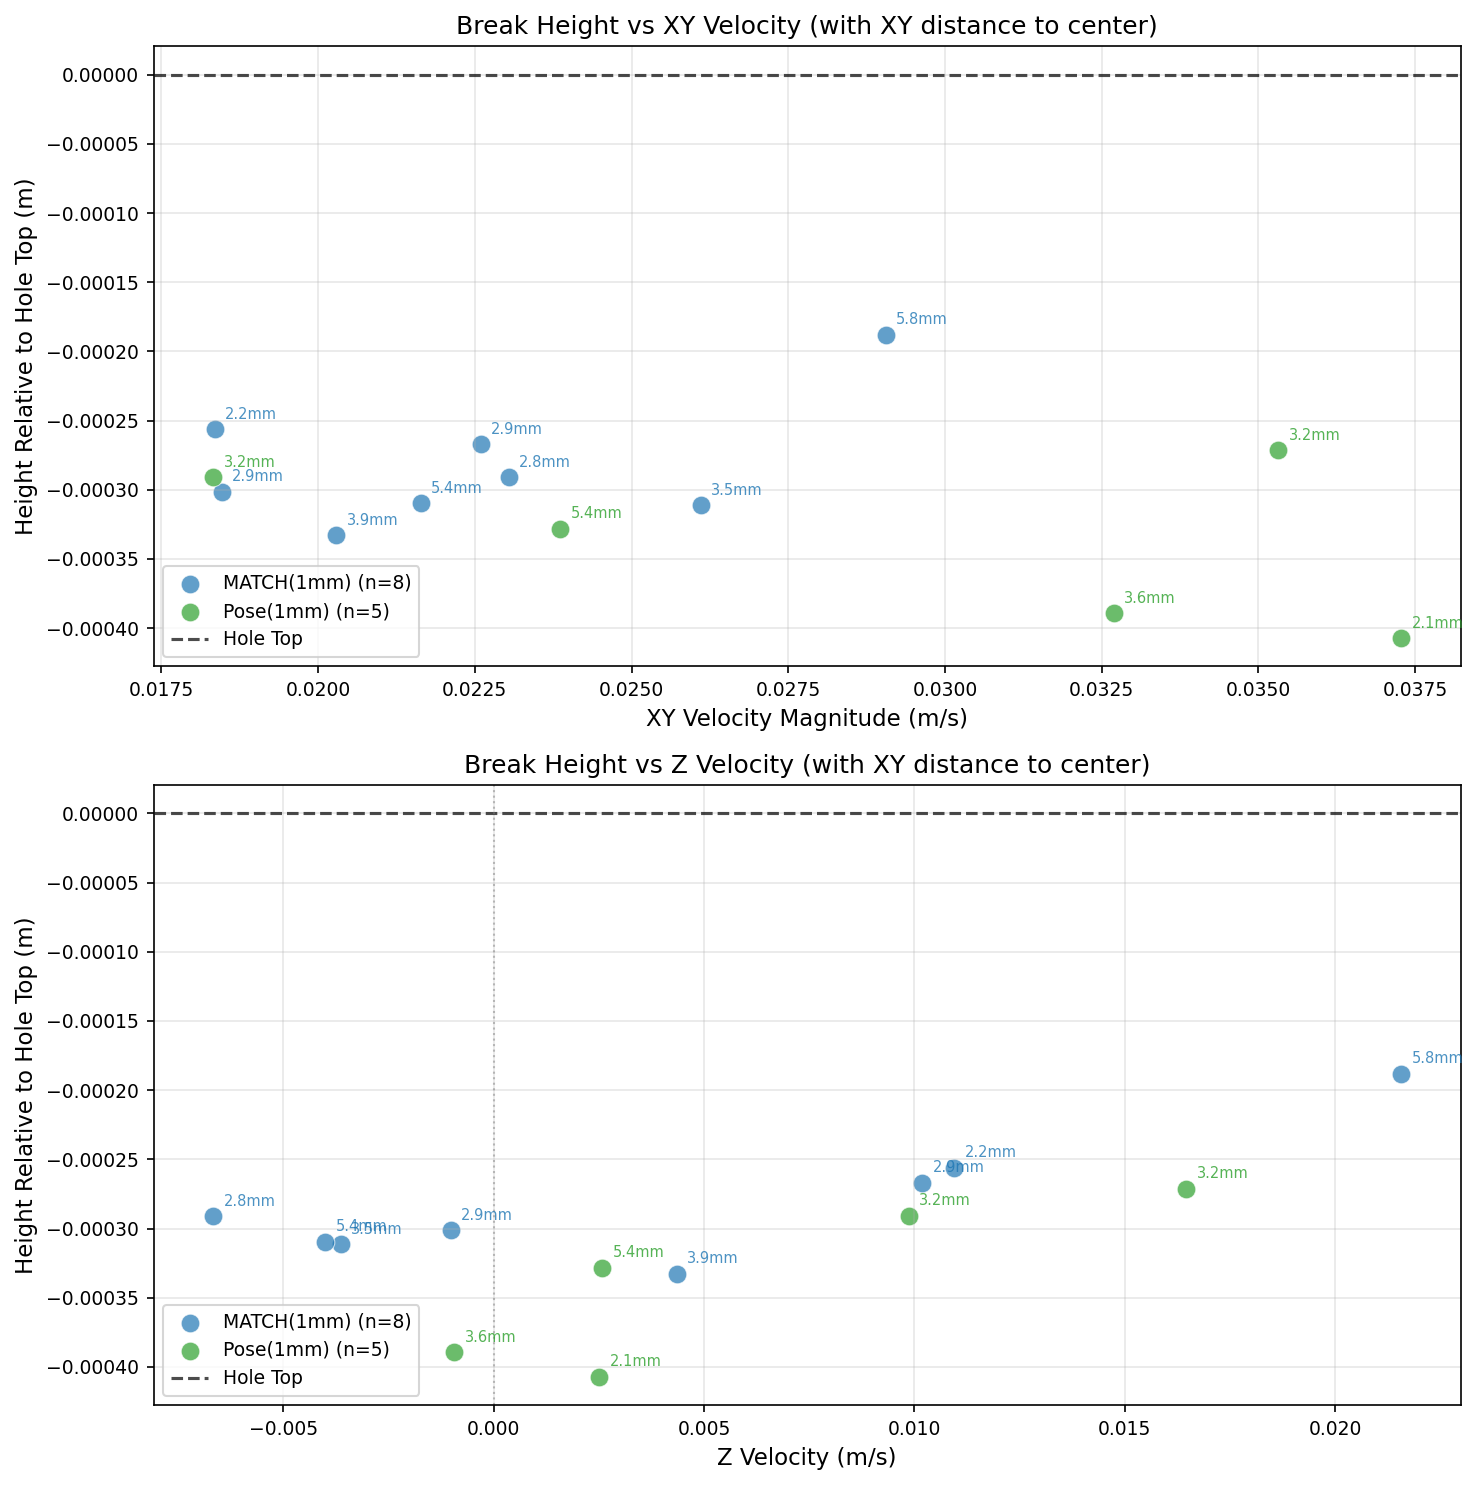

In [ ]:
# ============================================================
# BLOCK 11: BREAK HEIGHT VS VELOCITY
# ============================================================
#
# Two stacked scatter plots showing for each break event:
# - Top: XY-plane velocity (magnitude) vs height relative to hole top
# - Bottom: Z-velocity vs height relative to hole top
# - Text annotation: XY distance to hole center (mm)

# Plot Configuration
FIGSIZE_VELOCITY = (10, 10)

# ============================================================

def plot_break_height_vs_velocity(episode_data, hole_depth=0.025, figsize=(10, 10)):
    """
    Two stacked scatter plots of break height vs velocity.
    
    Top plot: XY velocity magnitude on x-axis
    Bottom plot: Z velocity on x-axis
    Both plots: Height relative to hole top on y-axis
    
    Args:
        episode_data: List of episode dicts
        hole_depth: Depth of the hole in meters (default 0.025m = 2.5cm)
        figsize: Figure size
        
    Returns:
        matplotlib Figure
    """
    # Collect data for break episodes
    break_data = defaultdict(lambda: {
        'heights': [], 
        'xy_vels': [], 
        'z_vels': [], 
        'xy_dists': []
    })
    
    for ep in episode_data:
        if ep['outcome'] != 'break':
            continue
        
        policy = ep['policy']
        steps = ep['steps']
        hole_pos = ep.get('hole_pos')
        
        if not steps or hole_pos is None:
            continue
        
        # Get last step (at break)
        last_step = steps[-1]
        peg_pos = last_step.get('peg_pos')
        velocity = last_step.get('velocity')
        
        if peg_pos is None or len(peg_pos) < 3:
            continue
        if velocity is None or len(velocity) < 3:
            continue
        
        # Compute height relative to top of hole
        height = peg_pos[2] - hole_pos[2] - hole_depth
        
        # Compute XY velocity magnitude
        xy_vel = np.sqrt(velocity[0]**2 + velocity[1]**2)
        
        # Z velocity
        z_vel = velocity[2]
        
        # Compute XY distance to hole center
        xy_dist = np.sqrt((peg_pos[0] - hole_pos[0])**2 + (peg_pos[1] - hole_pos[1])**2)
        
        break_data[policy]['heights'].append(height)
        break_data[policy]['xy_vels'].append(xy_vel)
        break_data[policy]['z_vels'].append(z_vel)
        break_data[policy]['xy_dists'].append(xy_dist)
    
    if not any(break_data[p]['heights'] for p in break_data):
        print("No break events with valid velocity data found.")
        return None
    
    # Create figure with two stacked subplots
    fig, (ax_xy, ax_z) = plt.subplots(2, 1, figsize=figsize, dpi=DPI)
    
    for policy in sorted(break_data.keys()):
        data = break_data[policy]
        if not data['heights']:
            continue
        
        color = METHOD_COLORS.get(policy, 'gray')
        
        # Top plot: XY velocity vs height
        ax_xy.scatter(
            data['xy_vels'], 
            data['heights'],
            c=color,
            s=MARKER_SIZE,
            alpha=MARKER_ALPHA,
            label=f"{policy} (n={len(data['heights'])})",
            edgecolors='white',
            linewidths=0.5
        )
        
        # Add XY distance annotations
        for x, y, xy_dist in zip(data['xy_vels'], data['heights'], data['xy_dists']):
            xy_dist_mm = xy_dist * 1000
            ax_xy.annotate(
                f'{xy_dist_mm:.1f}mm',
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=7,
                color=color,
                alpha=0.8
            )
        
        # Bottom plot: Z velocity vs height
        ax_z.scatter(
            data['z_vels'], 
            data['heights'],
            c=color,
            s=MARKER_SIZE,
            alpha=MARKER_ALPHA,
            label=f"{policy} (n={len(data['heights'])})",
            edgecolors='white',
            linewidths=0.5
        )
        
        # Add XY distance annotations
        for x, y, xy_dist in zip(data['z_vels'], data['heights'], data['xy_dists']):
            xy_dist_mm = xy_dist * 1000
            ax_z.annotate(
                f'{xy_dist_mm:.1f}mm',
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=7,
                color=color,
                alpha=0.8
            )
    
    # Configure top plot (XY velocity)
    ax_xy.set_xlabel('XY Velocity Magnitude (m/s)', fontsize=FONT_AXIS_LABEL)
    ax_xy.set_ylabel('Height Relative to Hole Top (m)', fontsize=FONT_AXIS_LABEL)
    ax_xy.set_title('Break Height vs XY Velocity (with XY distance to center)', fontsize=FONT_TITLE)
    ax_xy.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='Hole Top')
    ax_xy.legend(fontsize=FONT_LEGEND, loc='best')
    ax_xy.tick_params(labelsize=FONT_TICK)
    ax_xy.grid(True, alpha=0.3)
    
    # Configure bottom plot (Z velocity)
    ax_z.set_xlabel('Z Velocity (m/s)', fontsize=FONT_AXIS_LABEL)
    ax_z.set_ylabel('Height Relative to Hole Top (m)', fontsize=FONT_AXIS_LABEL)
    ax_z.set_title('Break Height vs Z Velocity (with XY distance to center)', fontsize=FONT_TITLE)
    ax_z.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7, label='Hole Top')
    ax_z.axvline(x=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)  # Zero velocity reference
    ax_z.legend(fontsize=FONT_LEGEND, loc='best')
    ax_z.tick_params(labelsize=FONT_TICK)
    ax_z.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_break_height_vs_velocity(
        all_episode_data,
        hole_depth=HOLE_DEPTH,
        figsize=FIGSIZE_VELOCITY
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

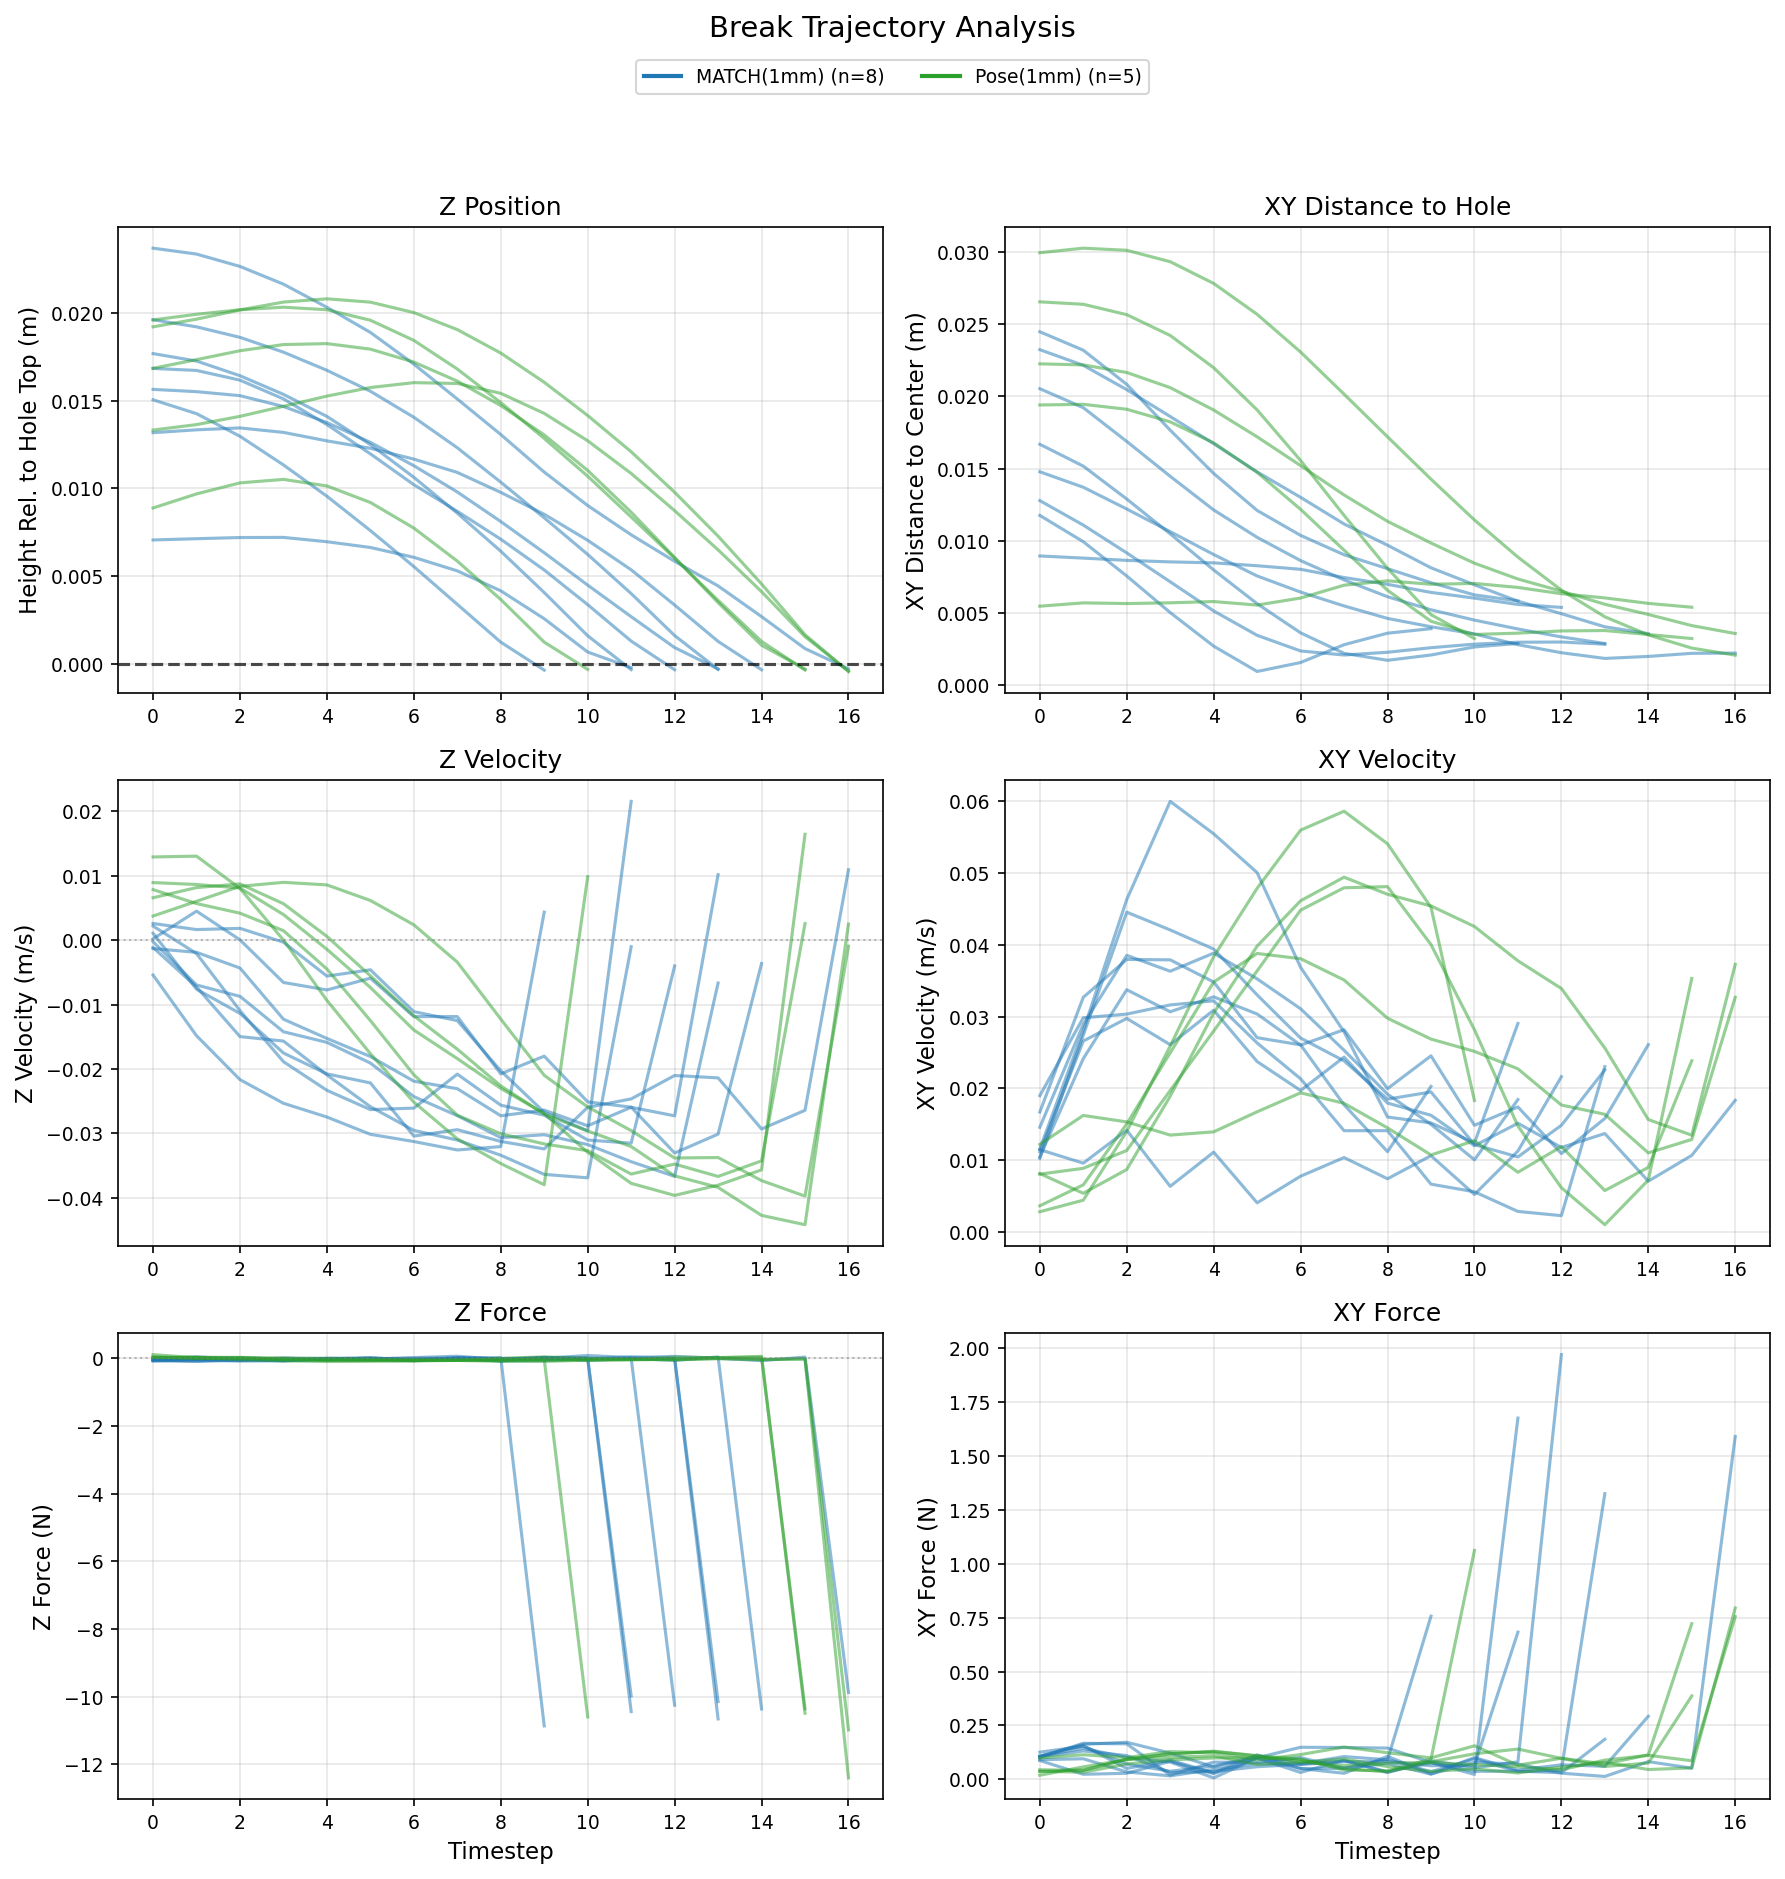

In [ ]:
# ============================================================
# BLOCK 12: BREAK TRAJECTORY ANALYSIS (6-PANEL)
# ============================================================
#
# 3x2 grid showing trajectories leading up to break:
# Left column (Z-related):
#   - Relative Z position (height relative to hole top)
#   - Z velocity
#   - Z force
# Right column (XY-related):
#   - XY distance to hole center
#   - XY velocity magnitude
#   - XY force magnitude
#
# X-axis: timesteps leading up to break

# Plot Configuration
FIGSIZE_BREAK_TRAJ = (12, 12)
LINE_ALPHA = 0.5
LINE_WIDTH = 1.5

# ============================================================

def plot_break_trajectory_analysis(episode_data, hole_depth=0.025, figsize=(12, 12)):
    """
    6-panel plot showing trajectories leading up to break events.
    
    Left column: Z-related (position, velocity, force)
    Right column: XY-related (distance, velocity, force)
    X-axis: timesteps (0 = start of episode)
    
    Args:
        episode_data: List of episode dicts
        hole_depth: Depth of the hole in meters
        figsize: Figure size
        
    Returns:
        matplotlib Figure
    """
    # Collect trajectory data for break episodes
    # Structure: {policy: [{'z_pos': [...], 'xy_dist': [...], ...}, ...]}
    break_trajectories = defaultdict(list)
    
    for ep in episode_data:
        if ep['outcome'] != 'break':
            continue
        
        policy = ep['policy']
        steps = ep['steps']
        hole_pos = ep.get('hole_pos')
        
        if not steps or hole_pos is None:
            continue
        
        # Extract trajectory data for each step
        traj = {
            'z_pos': [],
            'xy_dist': [],
            'z_vel': [],
            'xy_vel': [],
            'z_force': [],
            'xy_force': [],
            'timesteps': []
        }
        
        for i, step in enumerate(steps):
            peg_pos = step.get('peg_pos')
            velocity = step.get('velocity')
            force = step.get('contact_force')
            
            if peg_pos is None or len(peg_pos) < 3:
                continue
            if velocity is None or len(velocity) < 3:
                continue
            if force is None or len(force) < 3:
                continue
            
            # Z position relative to hole top
            z_pos = peg_pos[2] - hole_pos[2] - hole_depth
            
            # XY distance to hole center
            xy_dist = np.sqrt((peg_pos[0] - hole_pos[0])**2 + (peg_pos[1] - hole_pos[1])**2)
            
            # Velocities
            z_vel = velocity[2]
            xy_vel = np.sqrt(velocity[0]**2 + velocity[1]**2)
            
            # Forces
            z_force = force[2]
            xy_force = np.sqrt(force[0]**2 + force[1]**2)
            
            traj['z_pos'].append(z_pos)
            traj['xy_dist'].append(xy_dist)
            traj['z_vel'].append(z_vel)
            traj['xy_vel'].append(xy_vel)
            traj['z_force'].append(z_force)
            traj['xy_force'].append(xy_force)
            traj['timesteps'].append(i)
        
        if traj['timesteps']:
            break_trajectories[policy].append(traj)
    
    if not any(break_trajectories[p] for p in break_trajectories):
        print("No break trajectories found.")
        return None
    
    # Create 3x2 figure
    fig, axes = plt.subplots(3, 2, figsize=figsize, dpi=DPI)
    
    # Define what to plot in each cell
    # (row, col): (data_key, ylabel, title)
    plot_config = {
        (0, 0): ('z_pos', 'Height Rel. to Hole Top (m)', 'Z Position'),
        (0, 1): ('xy_dist', 'XY Distance to Center (m)', 'XY Distance to Hole'),
        (1, 0): ('z_vel', 'Z Velocity (m/s)', 'Z Velocity'),
        (1, 1): ('xy_vel', 'XY Velocity (m/s)', 'XY Velocity'),
        (2, 0): ('z_force', 'Z Force (N)', 'Z Force'),
        (2, 1): ('xy_force', 'XY Force (N)', 'XY Force'),
    }
    
    # Plot each trajectory
    for policy in sorted(break_trajectories.keys()):
        color = METHOD_COLORS.get(policy, 'gray')
        trajectories = break_trajectories[policy]
        
        for traj in trajectories:
            timesteps = traj['timesteps']
            
            for (row, col), (data_key, ylabel, title) in plot_config.items():
                ax = axes[row, col]
                data = traj[data_key]
                ax.plot(timesteps, data, color=color, alpha=LINE_ALPHA, linewidth=LINE_WIDTH)
    
    # Configure each subplot
    for (row, col), (data_key, ylabel, title) in plot_config.items():
        ax = axes[row, col]
        ax.set_ylabel(ylabel, fontsize=FONT_AXIS_LABEL)
        ax.set_title(title, fontsize=FONT_TITLE)
        ax.tick_params(labelsize=FONT_TICK)
        ax.grid(True, alpha=0.3)
        
        # Add reference lines
        if data_key == 'z_pos':
            ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
        elif data_key in ['z_vel', 'z_force']:
            ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        # X-axis label only on bottom row
        if row == 2:
            ax.set_xlabel('Timestep', fontsize=FONT_AXIS_LABEL)
    
    # Create legend from policy colors
    legend_handles = []
    for policy in sorted(break_trajectories.keys()):
        color = METHOD_COLORS.get(policy, 'gray')
        n_breaks = len(break_trajectories[policy])
        legend_handles.append(plt.Line2D([0], [0], color=color, linewidth=2, label=f'{policy} (n={n_breaks})'))
    
    fig.legend(handles=legend_handles, loc='upper center', ncol=len(legend_handles), 
               fontsize=FONT_LEGEND, bbox_to_anchor=(0.5, 1.02))
    
    plt.suptitle('Break Trajectory Analysis', fontsize=FONT_TITLE + 2, y=1.04)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_break_trajectory_analysis(
        all_episode_data,
        hole_depth=HOLE_DEPTH,
        figsize=FIGSIZE_BREAK_TRAJ
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

In [ ]:
# ============================================================
# BLOCK 13: SUCCESS TRAJECTORY ANALYSIS (6-PANEL)
# ============================================================
#
# 3x2 grid showing successful trajectories:
# Left column (Z-related):
#   - Relative Z position (height relative to hole top)
#   - Z velocity
#   - Z force
# Right column (XY-related):
#   - XY distance to hole center
#   - XY velocity magnitude
#   - XY force magnitude
#
# X-axis: timesteps

# Plot Configuration
FIGSIZE_SUCCESS_TRAJ = (12, 12)
SUCCESS_LINE_ALPHA = 0.3  # Lower alpha since there are more trajectories
SUCCESS_LINE_WIDTH = 1.0

# Limit number of trajectories per policy to avoid clutter
MAX_SUCCESS_TRAJECTORIES = 20  # Set to None for all

# Policies to include (exclude Pose)
SUCCESS_POLICIES = ['SWISH', 'Hybrid-Basic']

# ============================================================

def plot_success_trajectory_analysis(episode_data, hole_depth=0.025, max_per_policy=20, 
                                      policies_to_include=None, figsize=(12, 12)):
    """
    6-panel plot showing successful trajectories.
    
    Left column: Z-related (position, velocity, force)
    Right column: XY-related (distance, velocity, force)
    X-axis: timesteps (0 = start of episode)
    
    Args:
        episode_data: List of episode dicts
        hole_depth: Depth of the hole in meters
        max_per_policy: Max trajectories to plot per policy (None for all)
        policies_to_include: List of policy names to include (None for all)
        figsize: Figure size
        
    Returns:
        matplotlib Figure
    """
    # Collect trajectory data for success episodes
    success_trajectories = defaultdict(list)
    
    for ep in episode_data:
        if ep['outcome'] != 'success':
            continue
        
        policy = ep['policy']
        
        # Filter by policy if specified
        if policies_to_include is not None and policy not in policies_to_include:
            continue
        
        steps = ep['steps']
        hole_pos = ep.get('hole_pos')
        
        if not steps or hole_pos is None:
            continue
        
        # Extract trajectory data for each step
        traj = {
            'z_pos': [],
            'xy_dist': [],
            'z_vel': [],
            'xy_vel': [],
            'z_force': [],
            'xy_force': [],
            'timesteps': []
        }
        
        for i, step in enumerate(steps):
            peg_pos = step.get('peg_pos')
            velocity = step.get('velocity')
            force = step.get('contact_force')
            
            if peg_pos is None or len(peg_pos) < 3:
                continue
            if velocity is None or len(velocity) < 3:
                continue
            if force is None or len(force) < 3:
                continue
            
            # Z position relative to hole top
            z_pos = peg_pos[2] - hole_pos[2] - hole_depth
            
            # XY distance to hole center
            xy_dist = np.sqrt((peg_pos[0] - hole_pos[0])**2 + (peg_pos[1] - hole_pos[1])**2)
            
            # Velocities
            z_vel = velocity[2]
            xy_vel = np.sqrt(velocity[0]**2 + velocity[1]**2)
            
            # Forces
            z_force = force[2]
            xy_force = np.sqrt(force[0]**2 + force[1]**2)
            
            traj['z_pos'].append(z_pos)
            traj['xy_dist'].append(xy_dist)
            traj['z_vel'].append(z_vel)
            traj['xy_vel'].append(xy_vel)
            traj['z_force'].append(z_force)
            traj['xy_force'].append(xy_force)
            traj['timesteps'].append(i)
        
        if traj['timesteps']:
            success_trajectories[policy].append(traj)
    
    if not any(success_trajectories[p] for p in success_trajectories):
        print("No success trajectories found.")
        return None
    
    # Create 3x2 figure
    fig, axes = plt.subplots(3, 2, figsize=figsize, dpi=DPI)
    
    # Define what to plot in each cell
    plot_config = {
        (0, 0): ('z_pos', 'Height Rel. to Hole Top (m)', 'Z Position'),
        (0, 1): ('xy_dist', 'XY Distance to Center (m)', 'XY Distance to Hole'),
        (1, 0): ('z_vel', 'Z Velocity (m/s)', 'Z Velocity'),
        (1, 1): ('xy_vel', 'XY Velocity (m/s)', 'XY Velocity'),
        (2, 0): ('z_force', 'Z Force (N)', 'Z Force'),
        (2, 1): ('xy_force', 'XY Force (N)', 'XY Force'),
    }
    
    # Track total counts for legend
    total_counts = {}
    
    # Plot each trajectory
    for policy in sorted(success_trajectories.keys()):
        color = METHOD_COLORS.get(policy, 'gray')
        trajectories = success_trajectories[policy]
        total_counts[policy] = len(trajectories)
        
        # Limit number of trajectories if specified
        if max_per_policy is not None and len(trajectories) > max_per_policy:
            # Randomly sample
            np.random.seed(42)  # For reproducibility
            indices = np.random.choice(len(trajectories), max_per_policy, replace=False)
            trajectories = [trajectories[i] for i in indices]
        
        for traj in trajectories:
            timesteps = traj['timesteps']
            
            for (row, col), (data_key, ylabel, title) in plot_config.items():
                ax = axes[row, col]
                data = traj[data_key]
                ax.plot(timesteps, data, color=color, alpha=SUCCESS_LINE_ALPHA, linewidth=SUCCESS_LINE_WIDTH)
    
    # Configure each subplot
    for (row, col), (data_key, ylabel, title) in plot_config.items():
        ax = axes[row, col]
        ax.set_ylabel(ylabel, fontsize=FONT_AXIS_LABEL)
        ax.set_title(title, fontsize=FONT_TITLE)
        ax.tick_params(labelsize=FONT_TICK)
        ax.grid(True, alpha=0.3)
        
        # Add reference lines
        if data_key == 'z_pos':
            ax.axhline(y=0, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
            ax.axhline(y=-hole_depth, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
        elif data_key in ['z_vel', 'z_force']:
            ax.axhline(y=0, color='gray', linestyle=':', linewidth=1, alpha=0.5)
        
        # X-axis label only on bottom row
        if row == 2:
            ax.set_xlabel('Timestep', fontsize=FONT_AXIS_LABEL)
    
    # Create legend from policy colors
    legend_handles = []
    for policy in sorted(success_trajectories.keys()):
        color = METHOD_COLORS.get(policy, 'gray')
        n_total = total_counts[policy]
        n_shown = min(n_total, max_per_policy) if max_per_policy else n_total
        label = f'{policy} (n={n_shown}/{n_total})' if max_per_policy and n_total > max_per_policy else f'{policy} (n={n_total})'
        legend_handles.append(plt.Line2D([0], [0], color=color, linewidth=2, label=label))
    
    fig.legend(handles=legend_handles, loc='upper center', ncol=len(legend_handles), 
               fontsize=FONT_LEGEND, bbox_to_anchor=(0.5, 1.02))
    
    plt.suptitle('Success Trajectory Analysis', fontsize=FONT_TITLE + 2, y=1.04)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    return fig

# Generate the plot
if all_episode_data:
    fig = plot_success_trajectory_analysis(
        all_episode_data,
        hole_depth=HOLE_DEPTH,
        max_per_policy=MAX_SUCCESS_TRAJECTORIES,
        policies_to_include=SUCCESS_POLICIES,
        figsize=FIGSIZE_SUCCESS_TRAJ
    )
    if fig:
        plt.show()
else:
    print("No episode data loaded.")

No success trajectories found.
